# Descrição técnica

- Nome do teste: `recommender_system_test`
- Grupos: A (controle) B (funil de novos pagamentos)
- Data de início: 07-12-2020
- Data de quando pararam de receber novos usuários: 21-12-2020
- Data de término: 01-01-2021
- Público: 15% de novos usuários da região da UE
- Propósito do teste: testando mudanças relacionadas à introdução de uma recomendação do sistema melhorada
- Resultado esperado: em até 14 dias após o cadastro, usuários mostram uma conversão melhor nas visualizações de página do produto (o evento `product_page` event), ao adicionar itens ao carrinho (`product_cart`), e compras (`purchase`). A cada etapa do funil `product_page → product_cart → purchase`, terá ao menos 10% de aumento.
- Número esperado de participantes do teste: 6000


## Descrição dos dados

- `ab_project_marketing_events_us.csv` — o calendário de eventos de marketing para 2020
- `final_ab_new_users_upd_us.csv` — todos os usuários que se cadastraram na loja online de 7 de dezembro a 21, de 2020
- `final_ab_events_upd_us.csv` — todos os eventos dos novos usuários dentro do período de 7 de dezembro, de 2020 até 1 de janeiro, de 2021
- `final_ab_participants_upd_us.csv` — tabela contendo os participantes do teste

### Estrutura `ab_project__marketing_events_us.csv`:

- `name` — do nome dos eventos de marketing
- `regions` — das regiões onde a campanha será realizada
- `start_dt` — de data de início da campanha
- `finish_dt` — da data de término da campanha

### Estrutura `final_ab_new_users_upd_us.csv`:

- `user_id`
- `first_date` — da data de cadastro
- `region` 
- `device` — do dispositivo usado para o cadastro

### Estrutura `final_ab_events_upd_us.csv`:

- `user_id`
- `event_dt` — da data e hora do evento
- `event_name` — do nome da fonte do evento
- `details` — dos dados adicionais sobre o evento (por exemplo, o total do pedido em USD para eventos `purchase`)

### Estrutura `final_ab_participants_upd_us.csv`:

- `user_id`
- `ab_test` — nome do teste
- `group` — o grupo de teste ao qual o usuário pertencia


# Introdução

O objetivo do presente projeto é verificar se a mudança relacionada à melhoria do sistema de recomendação gerou o resultados esperados de que em até 14 dias, à partir de 7 dezembro de 2020 até dia 21 de dezembro de 2020, seja mostrada uma conversão de pelo menos 10% nas visualizações das páginas dos produtos e em cada etapa do funil, a saber: 

- login
- pagina do produto;
- adicionar itens ao carrinho;
- e compras. 

O público alvo será 15% dos novos usuários da Europa(UE).


Será realizada uma Análise Exploratória dos Dados com o intuito de auferir respostas às seguintes perguntas:

- Qual a porcentagem da conversão em diferentes etapas do funil.
- O número de eventos por usuário é distribuído igualmente entre as amostras?
- Os usuários de ambas as amostras estão presentes?
- Como o número de eventos é distribuído entre os dias?
- Existem quaisquer particularidades nos dados que você devam ser consideradas antes de começar o teste A/B?

Respondidas essas peguntas dar-se-á início ao teste A/B, que tem por finalidade testar se as mudanças implementadas no grupo de teste possui uma taxa de conversão maior que o grupo de controle.

No decorrer da preparação para o teste A/B será feito um teste de Levene, para saber se há homogeneidade de variância e um teste de Kolmogorov-Smirnov ou Shapiro-Wilk para verificar se amostra segue uma distribuição normal , caso não haja violação de nenhum desses pressupostos, será feito um Z-teste ou T-teste para verificar a diferença estatística entre as amostras; caso haja somente heterogeneidade de variância poderá ser realizado um T-teste de Welch, caso nenhum dos pressupostos seja atendidos, ou seja a variância das amostras é heterogênia e não são um distribuição normal o teste de Mann-Whitney será feito.

O teste A/B se desdobrará da seguinte forma:


- Teste de normalidade: Em que será verificada se as amostras de cada grupo (A e B) seguem uma distribuição normal. Isso pode ser feito usando testes estatísticos como o teste de Kolmogorov-Smirnov ou o teste de Shapiro-Wilk, embora o teste de Shapiro-Wilk seja adequado para amostras pequenas, também pode ser aplicado a amostras grandes. No decorrer da análise dos dados será decidido.


- Teste de homogeneidade de variância: Onde será verificada se as variâncias das amostras dos grupos A e B são estatisticamente iguais. O teste de Levene será usado para isso.


- Teste de hipótese: Onde será realizado um teste estatístico adequado para comparar as médias dos grupos A e B. Se os dados atenderem aos pressupostos paramétricos (normalidade e homogeneidade de variância), será usado o teste T de Student ou o teste T de Welch. O teste T de Welch é uma alternativa ao teste T de Student quando há uma violação do pressuposto de homogeneidade de variância, mas ainda há uma suposição de normalidade. Se os dados não atenderem aos pressupostos paramétricos, será usado o teste de Mann-Whitney, que é um teste não paramétrico.


E por fim será descrito conclusões sobre a etapa da AED e do resultado do teste A/B.


# Importando Biblioteca

In [46]:
import pandas as pd
import numpy as np
import scipy.stats as stats


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

sns.set_theme()


import warnings
warnings.filterwarnings('ignore')



# Carregando Dataframes

In [47]:
try: 
    events = pd.read_csv('ab_project_marketing_events_us.csv')
    events_ab = pd.read_csv('final_ab_events_upd_us.csv')
    new_users_ab = pd.read_csv('final_ab_new_users_upd_us.csv')
    participants_ab = pd.read_csv('final_ab_participants_upd_us.csv')
except:
    events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
    events_ab = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
    new_users_ab = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
    participants_ab = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

# Funções Utilizadas

In [48]:
# Gráfico de Densidade

def kde_plot(data, x1="A", x2="B", end_data=str, ev=str):
    sns.kdeplot(data.query('group == @x1 & date <= @end_data')[ev], shade=True, label=x1)
    sns.kdeplot(data.query('group == @x2 & date <= @end_data')[ev], shade=True, label=x2)

    # Adicionar rótulos e título do gráfico
    plt.xlabel(f'{ev} ocorridos')
    plt.ylabel('Densidade')
    plt.title(f'KDE de {ev} filtrado até {end_data}')
    plt.legend()

    # Exibir o gráfico
    plt.show()
    

In [49]:
# Gráficos de linha

def line_plot(data, x1="A", x2="B", ev=str):
    plt.figure(figsize=(10,8))
    
    ax1 = plt.plot(data.query('group == @x1 & date <= "2020-12-21"')['date'], data.query('group == @x1 & date <= "2020-12-21"')[ev], 'go--', color='blue', label="A")
    ax2 = plt.plot(data.query('group == @x2 & date <= "2020-12-21"')['date'], data.query('group == @x2 & date <= "2020-12-21"')[ev], 'go--', color='red', label="B")
    
    # Adicionar rótulos e título do gráfico
    plt.title(f'Quantidade de {ev} entre 07/12/2020 e 21/12/2020')
    plt.xlabel('Data')
    plt.ylabel(f'Quantidade de usuários em: {ev}')
    plt.legend()

    # Exibir o gráfico
    plt.show()

In [50]:
# Gráfico de Caixa

def boxplot_plot(data, hue='group', y='ab_test', ev=str):
    plt.figure(figsize=(8,6))
    sns.boxplot(data=data, x=ev, y=y, orient='h', hue=hue)
    plt.title(f"Gráfico de Caixa do evento {ev} entre os grupos A/B ")
    plt.xlabel(f"{ev}")
    plt.ylabel("Teste A/B")

    plt.show()


# Pre-processamento dos dados

## Conhecendo os dados

In [51]:
sets = [events, events_ab, new_users_ab, participants_ab]

for i in sets:
    print('='*95)
    display(i.head(5))
    print('='*95)
    print('='*95)
    print(i.info())
    print('='*95)
    print(f'O dataframe é composto por {i.shape[0]} linhas e {i.shape[1]} colunas')
    print('='*95)
    print('='*95)
    print(f'O número de dados ausentes no dataframe é de: {(i.isnull().sum().sum())}, que corresponde a {round((i.isnull().sum().sum()/i.shape[0])*100, 2)}%, do dataframe')
    print('='*95)
    print()
    print()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None
O dataframe é composto por 14 linhas e 4 colunas
O número de dados ausentes no dataframe é de: 0, que corresponde a 0.0%, do dataframe




,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB
None
O dataframe é composto por 423761 linhas e 4 colunas
O número de dados ausentes no dataframe é de: 363447, que corresponde a 85.77%, do dataframe




,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
None
O dataframe é composto por 58703 linhas e 4 colunas
O número de dados ausentes no dataframe é de: 0, que corresponde a 0.0%, do dataframe




,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
None
O dataframe é composto por 14525 linhas e 3 colunas
O número de dados ausentes no dataframe é de: 0, que corresponde a 0.0%, do dataframe




Inicialmente percebe-se que no dataframe `events` as datas estão em formato object, ou seja, em formato de texto. Esse erro será tratado convertendo o formato dos dados referente a datas para o formato correto, sendo este o formato Datetime.

O dataframe `events_ab` possui 85,77% de dados ausentes na coluna `details`, que não são fruto de erros, pois tal coluna é referente aos valores de compra dos produtos quando o evento *purchase* é concluído. Portanto, enquanto a compra não for concluída não haverá dado na coluna. 


# Tratando os Dados

Os tratamentos serão poucos, já que os dados possuem poucos erros visíveis nesse primeiro momento. 

Logo, caso seja necessário qualquer outra manipulação com o intuito de tratar algum erro será feito no momento em que for identificado durante o código com as devidas ressalvas e explicações. 

No dataset `events_ab` será criado uma nova coluna apenas com as datas, sem as horas, com o intuito de facilitar eventuais manipulações.

In [52]:
events['start_dt']  = pd.to_datetime(events['start_dt'])
events['finish_dt'] = pd.to_datetime(events['finish_dt'])
events_ab['event_dt'] = pd.to_datetime(events_ab['event_dt'])
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [53]:
events_ab['date'] = events_ab['event_dt'].dt.floor('1D')
events_ab['weekday'] = events_ab['date'].dt.day_name()
events_ab

,user_id,event_dt,event_name,details,date,weekday
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,Monday
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,Monday
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,Monday
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,Monday
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,Monday
...,...,...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN,2020-12-30,Wednesday
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN,2020-12-30,Wednesday
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN,2020-12-30,Wednesday
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN,2020-12-30,Wednesday


## Preparando os Dados

A preparação dos dados se dará inicialmente com a criação dos DataFrames pertinentes para a análise, juntando os Datasets que possuam informações complementares e pertinentes para a análise.

Será criada um Dataframe com a fusão dos datasets:

- `new_users_ab`
- `participants_ab`
 
Para que seja possível separar os usuários nos grupos de teste **A** e **B** e nos testes `recommender_system_test`  e `interface_eu_test`

Após isso, serão separados os usuários que aparecem em ambos os testes e esses serão retirados. 

E com isso os dados estarão prontos para a plotagem de gráficos e montagem das `pivot_tables` para a testagem.

In [54]:
teste_merge = new_users_ab.query('first_date <= "2020-12-21"').merge(participants_ab, how='left', on='user_id')
teste_merge['ab_test'].fillna('-', inplace=True)
teste_merge['group'].fillna('-', inplace=True)
teste_merge_pivot = teste_merge.pivot_table(index=['ab_test', 'group'],
                                            columns='region',
                                            values='user_id',
                                            aggfunc='count')

teste_merge_pivot.fillna(0, inplace=True)
teste_merge_pivot

region                           APAC     CIS       EU  N.America
ab_test                 group                                    
-                       -      2811.0  2845.0  27024.0     8124.0
interface_eu_test       A         0.0     0.0   4978.0        0.0
                        B         0.0     0.0   4870.0        0.0
recommender_system_test A        28.0    19.0   2604.0       96.0
                        B        17.0    11.0    877.0       23.0

In [55]:
events_ab_pivot = events_ab.pivot_table(index='date',
                                       columns='event_name', 
                                       values='user_id', 
                                       aggfunc='count').reset_index().rename_axis(" ", axis=1)

events_ab_pivot['conversion'] = events_ab_pivot['purchase']/events_ab_pivot['login']

events_ab_pivot['conversion'] = events_ab_pivot['purchase'] / events_ab_pivot['login']
events_ab_pivot.head()


,date,login,product_cart,product_page,purchase,conversion
0,2020-12-07,4913,1582,3240,1650,0.335844
1,2020-12-08,5447,1744,3627,1729,0.317422
2,2020-12-09,5227,1704,3498,1693,0.323895
3,2020-12-10,6045,1998,4022,2012,0.332837
4,2020-12-11,6000,1949,3957,1958,0.326333


In [56]:
recommender_system_ab = teste_merge.query('ab_test == "recommender_system_test"')
recommender_system_ab.head()


,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
19,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test
23,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test
39,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test
40,29C92313A98B1176,2020-12-07,APAC,Android,B,recommender_system_test


In [57]:
interface_eu_ab = teste_merge.query('ab_test == "interface_eu_test"')
interface_eu_ab.head()


,user_id,first_date,region,device,group,ab_test
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
13,5BE017E9C8CC42F8,2020-12-07,EU,Android,B,interface_eu_test
17,96F27A054B191457,2020-12-07,EU,iPhone,B,interface_eu_test
20,DD4352CDCF8C3D57,2020-12-07,EU,Android,A,interface_eu_test


In [58]:
common_id = interface_eu_ab.merge(recommender_system_ab, on='user_id')
common_id = common_id['user_id']
common_id.head()

0    DD4352CDCF8C3D57
1    6A581C74EF4D5F44
2    2B06EB547B7AAD08
3    DF40EF85F55A958D
4    CBEFCA3BFDE4CC58
Name: user_id, dtype: object

In [59]:
recommender_system_ab = recommender_system_ab.query('user_id not in @common_id')
recommender_system_ab.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
23,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test
39,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test
40,29C92313A98B1176,2020-12-07,APAC,Android,B,recommender_system_test
45,7D1BFB181017EB46,2020-12-07,CIS,PC,B,recommender_system_test


In [60]:
interface_eu_ab = interface_eu_ab.query('user_id not in @common_id')
interface_eu_ab.head()

,user_id,first_date,region,device,group,ab_test
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
13,5BE017E9C8CC42F8,2020-12-07,EU,Android,B,interface_eu_test
17,96F27A054B191457,2020-12-07,EU,iPhone,B,interface_eu_test
21,E6AF85675078215D,2020-12-07,EU,Android,A,interface_eu_test


In [61]:

events_ab = pd.merge(events_ab, participants_ab, on='user_id')
events_ab.head()

,user_id,event_dt,event_name,details,date,weekday,group,ab_test
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,Monday,B,interface_eu_test
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,2020-12-08,Tuesday,B,interface_eu_test
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,2020-12-09,Wednesday,B,interface_eu_test
3,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,2020-12-26,Saturday,B,interface_eu_test
4,96F27A054B191457,2020-12-07 04:02:41,product_page,NaN,2020-12-07,Monday,B,interface_eu_test


In [62]:
events_ab = events_ab.query('user_id not in @common_id')
events_ab.head()

,user_id,event_dt,event_name,details,date,weekday,group,ab_test
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,Monday,B,interface_eu_test
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,2020-12-08,Tuesday,B,interface_eu_test
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,2020-12-09,Wednesday,B,interface_eu_test
3,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,2020-12-26,Saturday,B,interface_eu_test
4,96F27A054B191457,2020-12-07 04:02:41,product_page,NaN,2020-12-07,Monday,B,interface_eu_test


In [63]:
events_ab =  events_ab.merge(new_users_ab.query('user_id not in @common_id'), on='user_id')
events_ab.head()

,user_id,event_dt,event_name,details,date,weekday,group,ab_test,first_date,region,device
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,Monday,B,interface_eu_test,2020-12-07,EU,iPhone
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,2020-12-08,Tuesday,B,interface_eu_test,2020-12-07,EU,iPhone
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,2020-12-09,Wednesday,B,interface_eu_test,2020-12-07,EU,iPhone
3,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,2020-12-26,Saturday,B,interface_eu_test,2020-12-07,EU,iPhone
4,96F27A054B191457,2020-12-07 04:02:41,product_page,NaN,2020-12-07,Monday,B,interface_eu_test,2020-12-07,EU,iPhone


# Gráficos

### Histogramas

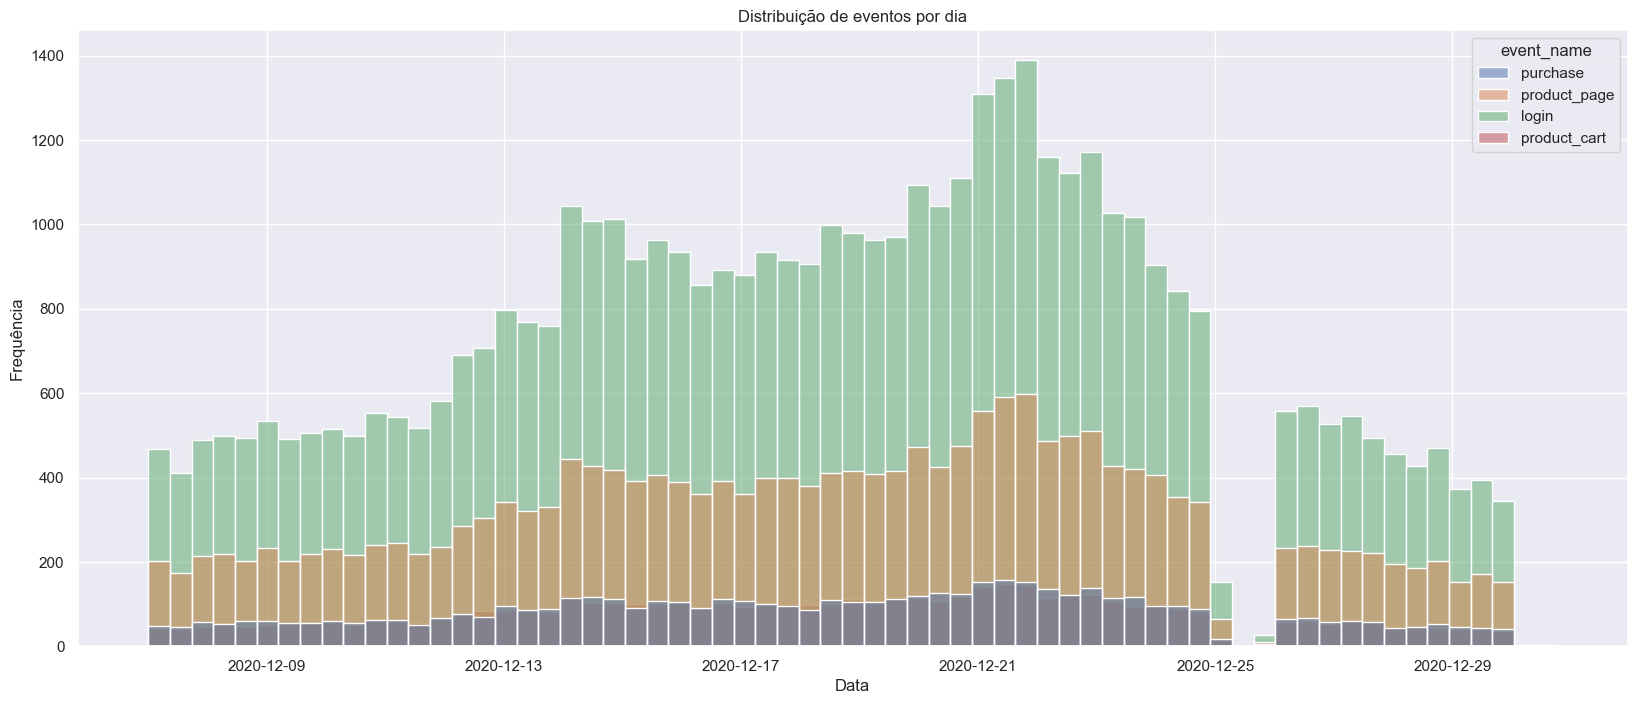

In [64]:
# Distribuição dos Eventos por dia no mês de Dezembro. 

plt.figure(figsize=(20,8))
sns.histplot(events_ab ,x='event_dt', stat='frequency', hue='event_name')
plt.title('Distribuição de eventos por dia')
plt.xlabel('Data')
plt.ylabel('Frequência')
plt.show()



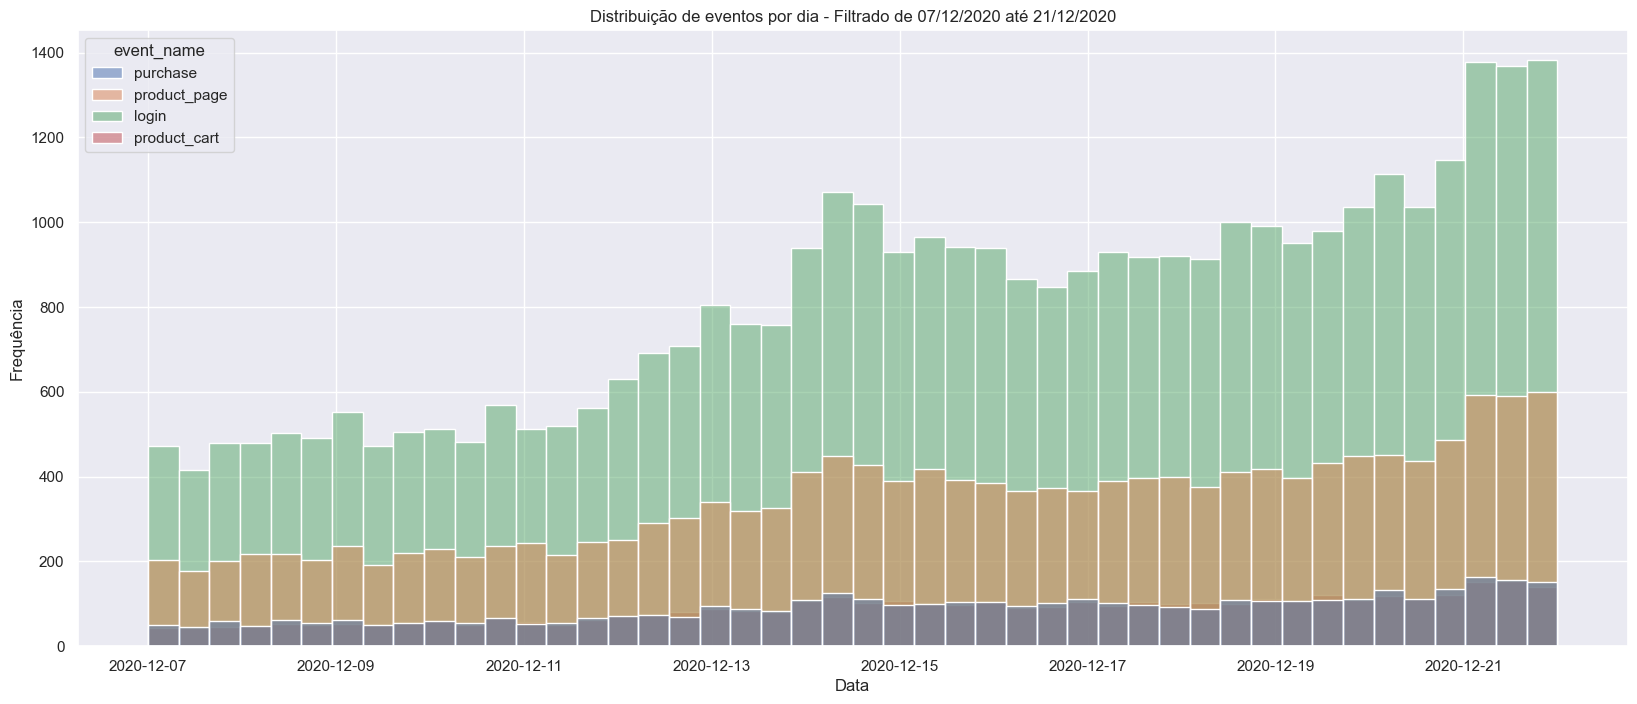

In [65]:
plt.figure(figsize=(20,8))
sns.histplot(events_ab.query('date <= "2020-12-21"') ,x='event_dt', stat='frequency', hue='event_name')
plt.title('Distribuição de eventos por dia - Filtrado de 07/12/2020 até 21/12/2020')
plt.xlabel('Data')
plt.ylabel('Frequência')
plt.show()

Percebe-se na observação dos hisogramas que há um crescimento com o passar dos dias, em relação os dias. Provavelmente, pela proximidade das festas de final de ano. 

### Gráfico de barras

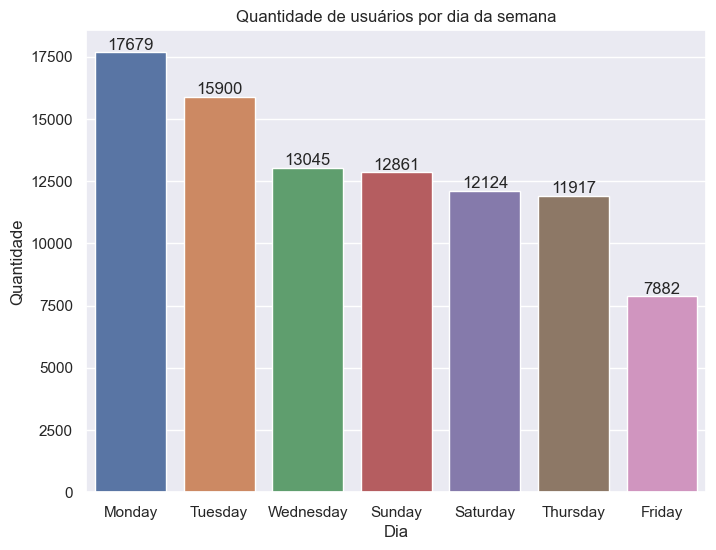

In [66]:
# Gráfico de quantidade de usuários por dia da semana

plt.figure(figsize=(8,6))
ax = sns.barplot(data=events_ab.groupby('weekday')['user_id'].count().reset_index().sort_values('user_id', ascending=False), x='weekday', y='user_id');
plt.title('Quantidade de usuários por dia da semana')
plt.xlabel('Dia')
plt.ylabel('Quantidade')


for i in ax.patches:
    ax.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()),
    ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.show();

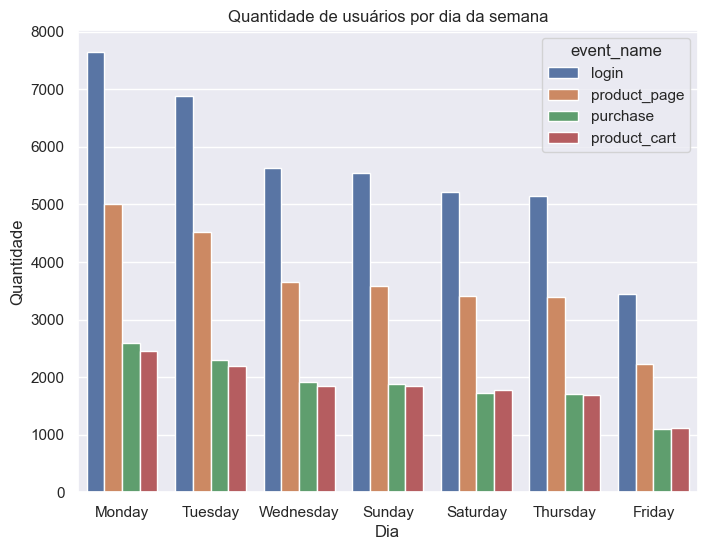

In [67]:
# Gráfico de quantidade de eventos por dia da semana

plt.figure(figsize=(8,6))
ax = sns.barplot(data=events_ab.groupby(['weekday', 'event_name'])['user_id'].count().reset_index().sort_values('user_id', ascending=False), x='weekday', y='user_id', hue='event_name');
plt.title('Quantidade de usuários por dia da semana')
plt.xlabel('Dia')
plt.ylabel('Quantidade')
plt.show();

Podemos observar que o dia com o maior números de usúarios e eventos foi a segunda.

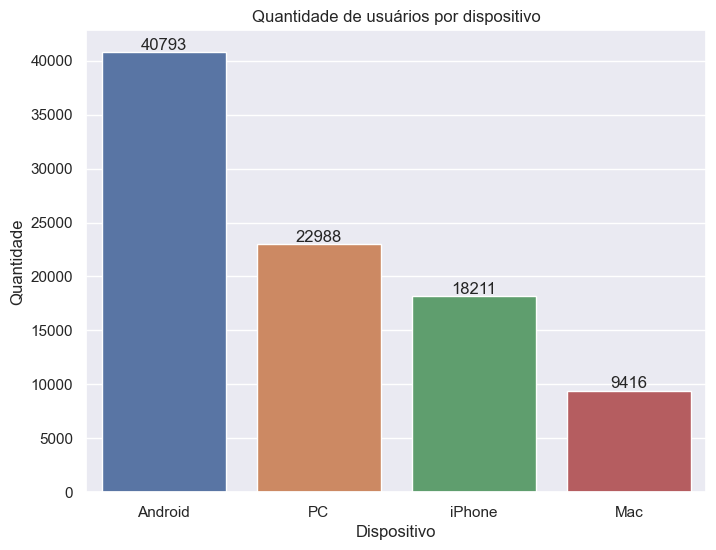

In [68]:
# Gráfico de quantidade de usuários por dispositivo

plt.figure(figsize=(8,6))
ax = sns.barplot(data=events_ab.groupby('device')['user_id'].count().reset_index().sort_values('user_id', ascending=False), x='device', y='user_id');
plt.title('Quantidade de usuários por dispositivo')
plt.xlabel('Dispositivo')
plt.ylabel('Quantidade')


for i in ax.patches:
    ax.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()),
    ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.show();


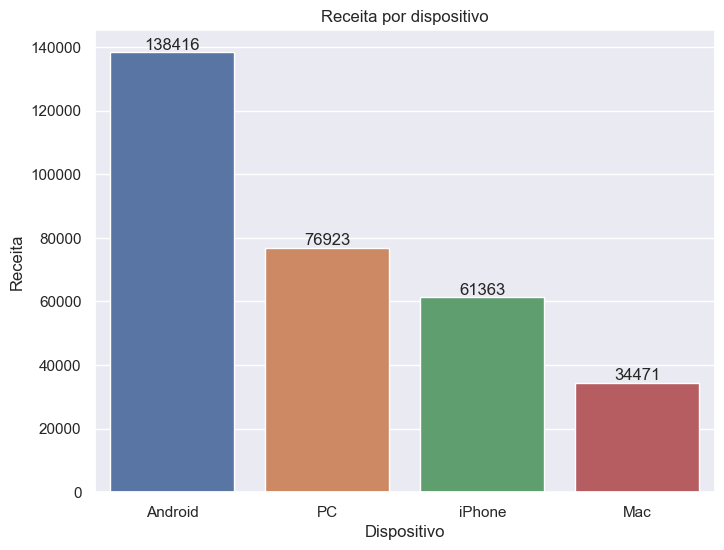

In [69]:
# Gráfico de barras de Receita por Dispositivo.

plt.figure(figsize=(8,6))
ax= sns.barplot(data=events_ab.groupby('device')['details'].sum().reset_index().sort_values('details', ascending=False),
            x='device',
            y='details');

plt.title('Receita por dispositivo')
plt.xlabel('Dispositivo')
plt.ylabel('Receita')



for i in ax.patches:
    ax.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()),
    ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.show();



Analisando os dados por dispositivos utilizados, vemos que Androids e PC lideram a quantidade de usuários e receita. 

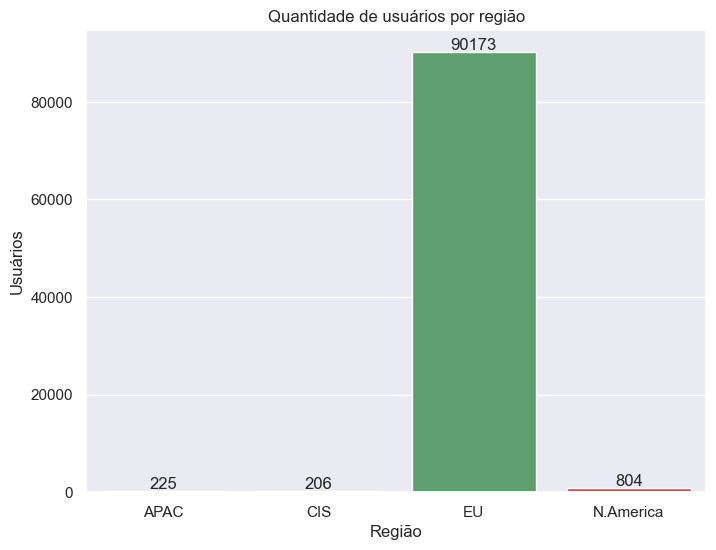

In [70]:
# Quantidade de Usuários por Região.


plt.figure(figsize=(8,6))
ax = sns.barplot(data=events_ab.groupby('region')['user_id'].count().reset_index(),
            x='region',
            y='user_id');

plt.title('Quantidade de usuários por região')
plt.xlabel('Região')
plt.ylabel('Usuários')



for i in ax.patches:
    ax.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()),
    ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.show();

Como o teste se dará na região da Europa, esse gráfico veio apenas como viés de confirmação dos números.

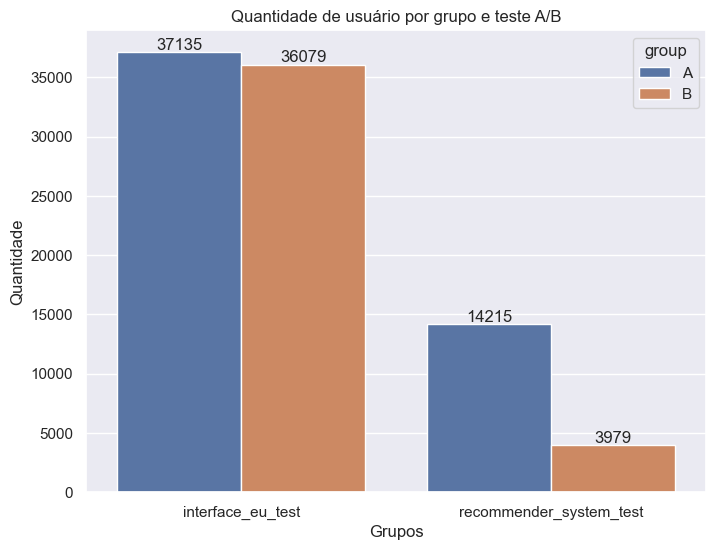

In [71]:
# Quantidade de usuários por Grupo nos testes AB

plt.figure(figsize=(8,6))
ax = sns.barplot(data=events_ab.groupby(['ab_test','group'])['user_id'].count().reset_index(), x='ab_test', y='user_id', hue='group');
plt.title('Quantidade de usuário por grupo e teste A/B')
plt.xlabel('Grupos')
plt.ylabel('Quantidade')

for i in ax.patches:
    ax.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() /2., i.get_height()),
                 ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
    
plt.show();

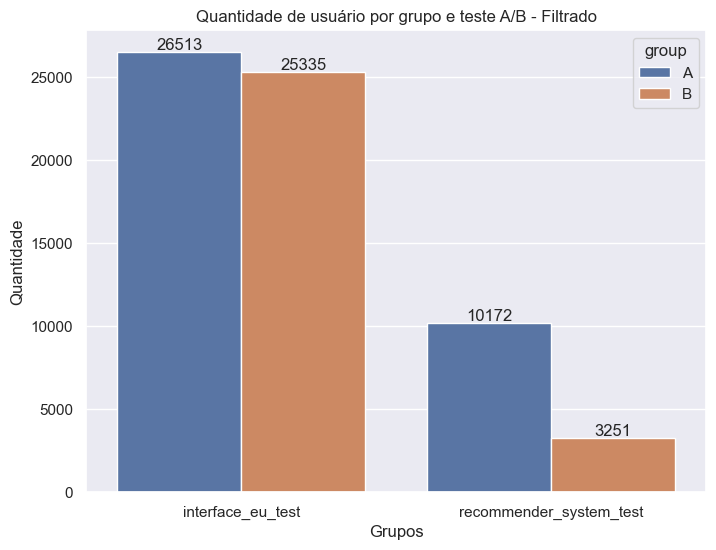

In [72]:
# Quantidade de usuários por Grupo nos testes AB entre 07/12/2020 e 21/12/2020


plt.figure(figsize=(8,6))
ax = sns.barplot(data=events_ab.query('date <= "2020-12-21"').groupby(['ab_test','group'])['user_id'].count().reset_index(), x='ab_test', y='user_id', hue='group');
plt.title('Quantidade de usuário por grupo e teste A/B - Filtrado')
plt.xlabel('Grupos')
plt.ylabel('Quantidade')

for i in ax.patches:
    ax.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() /2., i.get_height()),
                 ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
    
plt.show();

Podemos perceber que os dados do teste `interface_eu_test` possui uma quantidade interessante para os testes, enquanto o `recommender_system_test` possui um número bem menor de amostras.

Valse aslientar, que os dias com a maior quantidade de usuários foi a segunda.

A quantidade de amostras em ambos os testes são suficientes e nos grupos são o suficiente para os testes que serão feitos a seguir. 

### Funil de Eventos - Geral

In [73]:
events_ab_pivot = events_ab.pivot_table(index=['date', 'group'],
                                       columns=['event_name'], 
                                       values='user_id', 
                                       aggfunc='count').reset_index().rename_axis(" ", axis=1)

events_ab_pivot['conversion'] = events_ab_pivot['purchase']/events_ab_pivot['login']

events_ab_pivot['conversion'] = events_ab_pivot['purchase'] / events_ab_pivot['login']
events_ab_pivot.head()

,date,group,login,product_cart,product_page,purchase,conversion
0,2020-12-07,A,523.0,145.0,350.0,171.0,0.326960
1,2020-12-07,B,527.0,166.0,338.0,187.0,0.354839
2,2020-12-08,A,577.0,164.0,404.0,192.0,0.332756
3,2020-12-08,B,557.0,187.0,349.0,188.0,0.337522
4,2020-12-09,A,597.0,180.0,396.0,207.0,0.346734


In [74]:
frequency = events_ab.pivot_table(index='event_name',values='user_id',aggfunc='count').reset_index().sort_values(by='user_id', ascending=False)

frequency_filtered = frequency.reindex([0,2,1,3])


data = go.Funnel(
    y=frequency_filtered['event_name'],
    x=frequency_filtered['user_id'],
    textposition='inside',
    textinfo='value+percent previous'
    
)

layout = go.Layout(
    title='Funil de Eventos ocorridos'
    
)


fig = go.Figure(data=data, layout=layout)


fig.show()

In [75]:
frequency = events_ab.query('date <= "2020-12-21"').pivot_table(index='event_name',values='user_id',aggfunc='count').reset_index().sort_values('user_id', ascending=False)

frequency_filtered = frequency.reindex([0,2,1,3])


data = go.Funnel(
    y=frequency_filtered['event_name'],
    x=frequency_filtered['user_id'],
    textposition='inside',
    textinfo='value+percent previous'
    
)

layout = go.Layout(
    title='Funil de Eventos ocorridos - Filtrado entre 07/12/2020 e 21/12/2020 '
    
)


fig = go.Figure(data=data, layout=layout)


fig.show()

Os eventos são:
- login
- product_page (Página do produto)
- product_cart(Carrinho)
- purchase(Compra)

Aparentemente, o funil se dá em uma forma natural, as conversões parecem seguir uma linha "OK" exceto quando vemos que algumas compras são efetuadas sem passar pelo carrinho. O que leva a crer que existe uma função no site que leve a isso, ou alguma outra forma de compra é computada pelo site.

### Gráficos de Linha dos Grupos A e B geral

In [76]:

event_pivot = (pd.pivot_table(events_ab,
                              values='user_id',
                              index=['ab_test', 'date', 'group'], 
                              columns='event_name', 
                              aggfunc='count').reset_index().rename_axis('', axis=1)
              )
event_pivot['conversion'] = event_pivot['purchase'] / event_pivot['login']
cumsum_event = event_pivot.groupby('group').cumsum()
cumulative_event = pd.concat([event_pivot[['ab_test','date', 'group']], cumsum_event], axis=1)

cumulative_event.head()

,ab_test,date,group,login,product_cart,product_page,purchase,conversion
0,interface_eu_test,2020-12-07,A,414.0,120.0,280.0,141.0,0.340580
1,interface_eu_test,2020-12-07,B,403.0,130.0,255.0,140.0,0.347395
2,interface_eu_test,2020-12-08,A,870.0,254.0,598.0,303.0,0.695843
3,interface_eu_test,2020-12-08,B,873.0,291.0,560.0,302.0,0.692075
4,interface_eu_test,2020-12-09,A,1332.0,399.0,911.0,467.0,1.050821


In [77]:
event_interface_eu_test = event_pivot.query('ab_test == "interface_eu_test"')
event_recommender_system_test = event_pivot.query('ab_test == "recommender_system_test"')

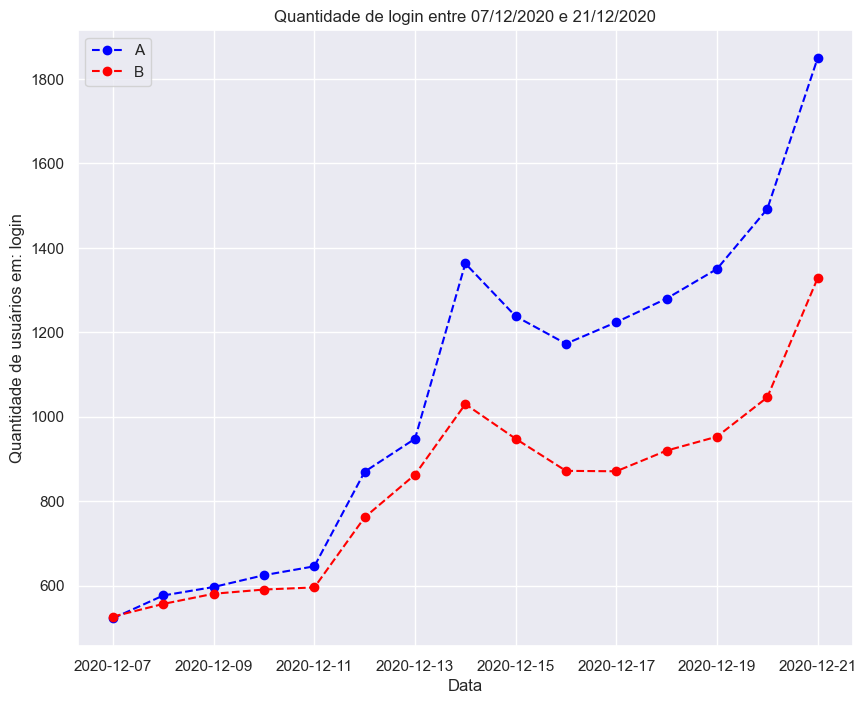

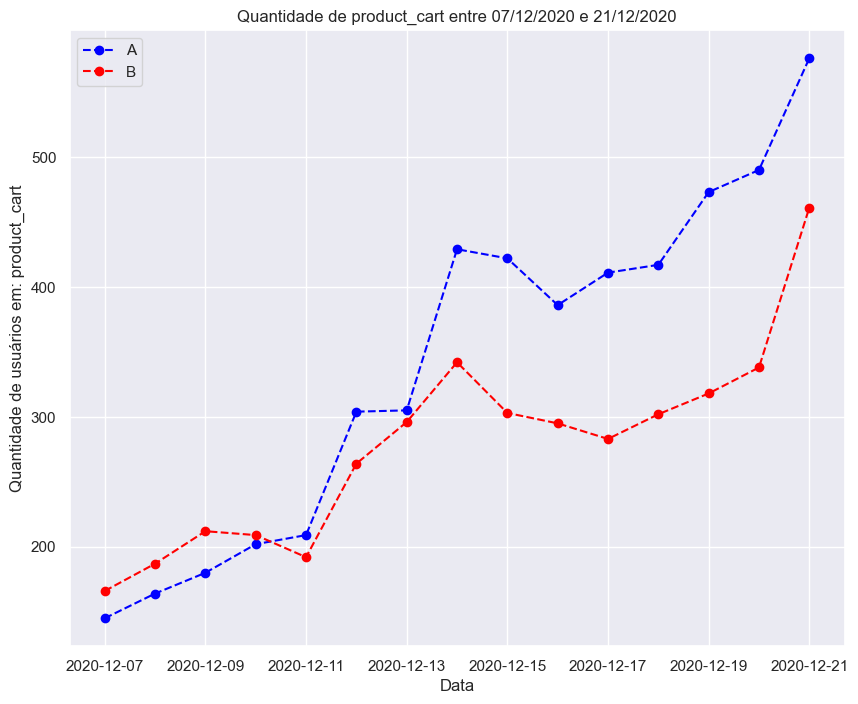

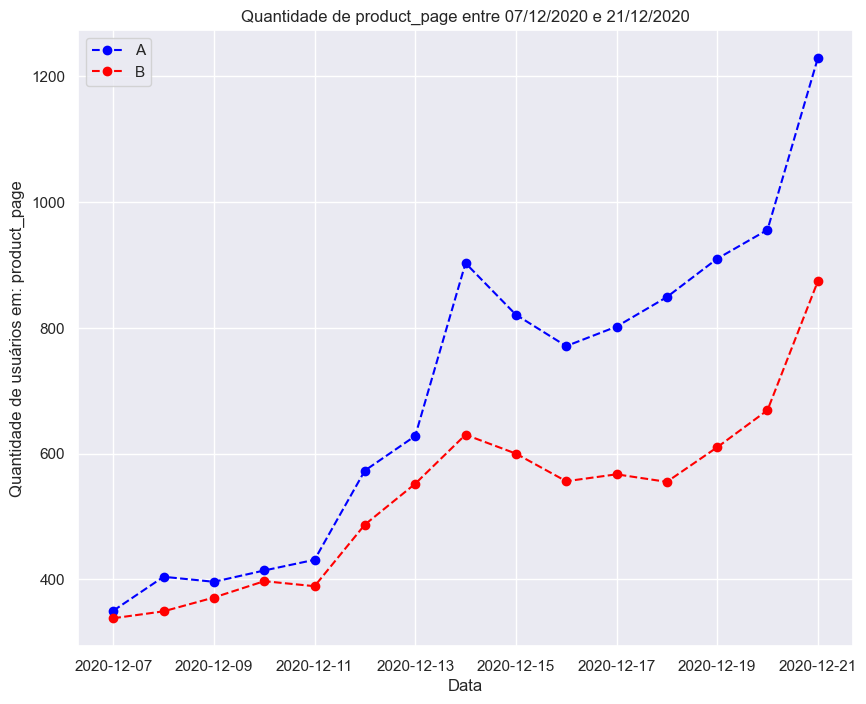

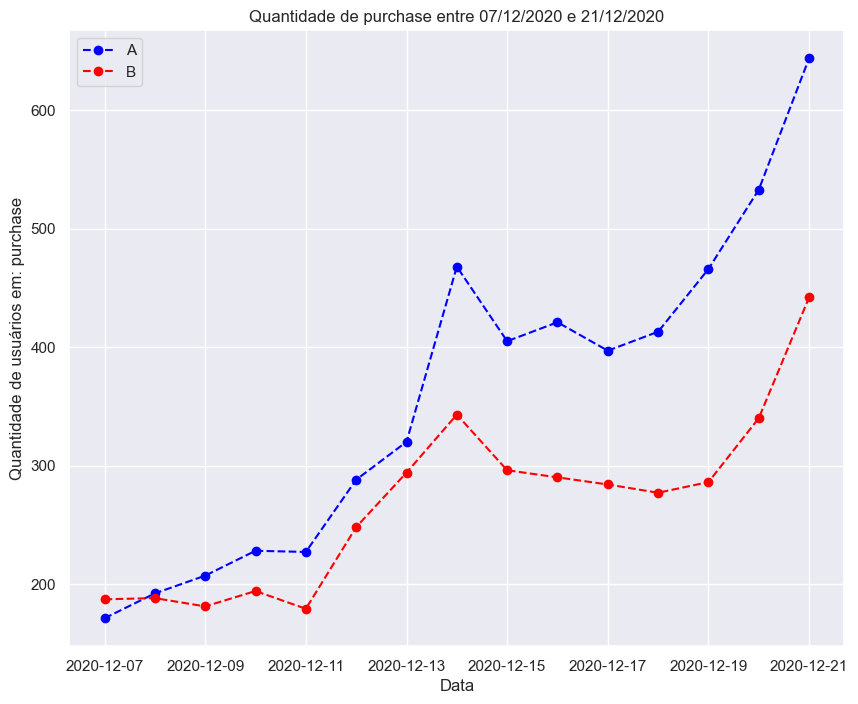

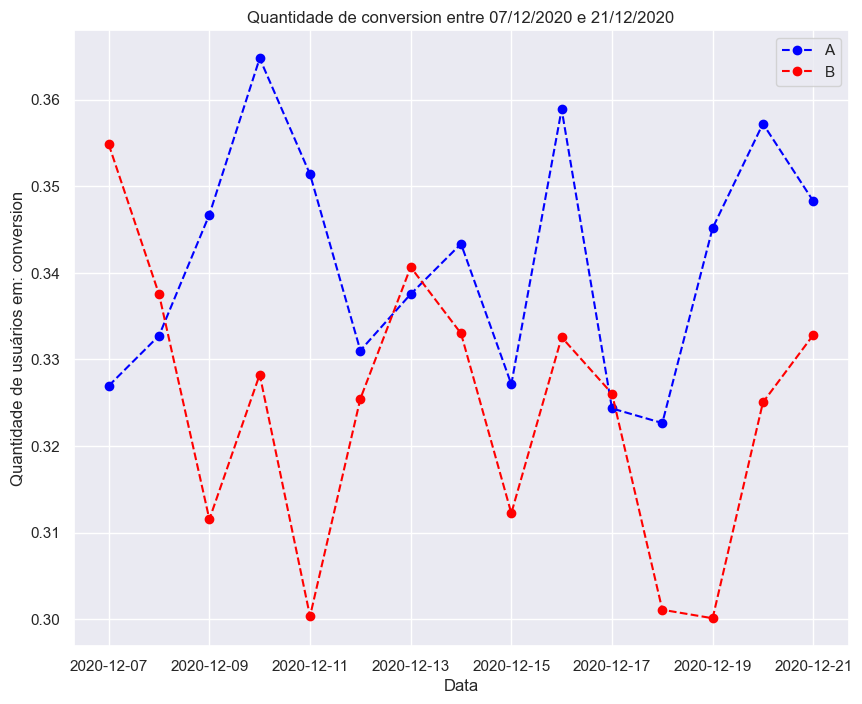

In [78]:
for i in events_ab_pivot.columns[2:]:

    line_plot(events_ab_pivot, ev=i)

Podemos ver que a evolução das variáveis são bem parecidas, seguindo entre ambos os grupos os mesmos padrões. 

In [79]:
event_interface_eu_test = event_pivot.query('ab_test == "interface_eu_test"')
event_recommender_system_test = event_pivot.query('ab_test == "recommender_system_test"')

### Plotagem de Gráficos de Linha dos Grupos A e B do event_interface_eu_test

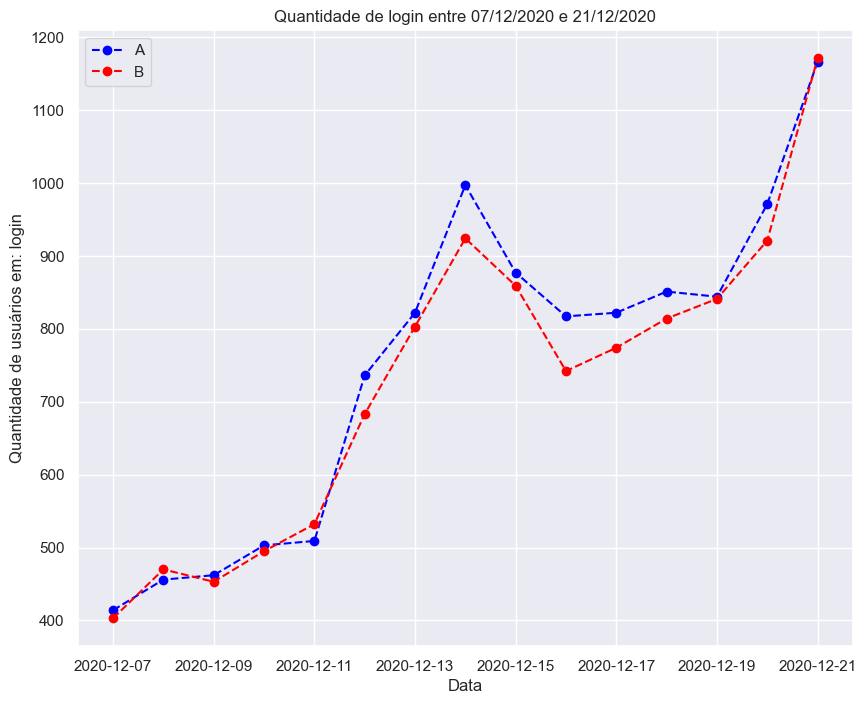

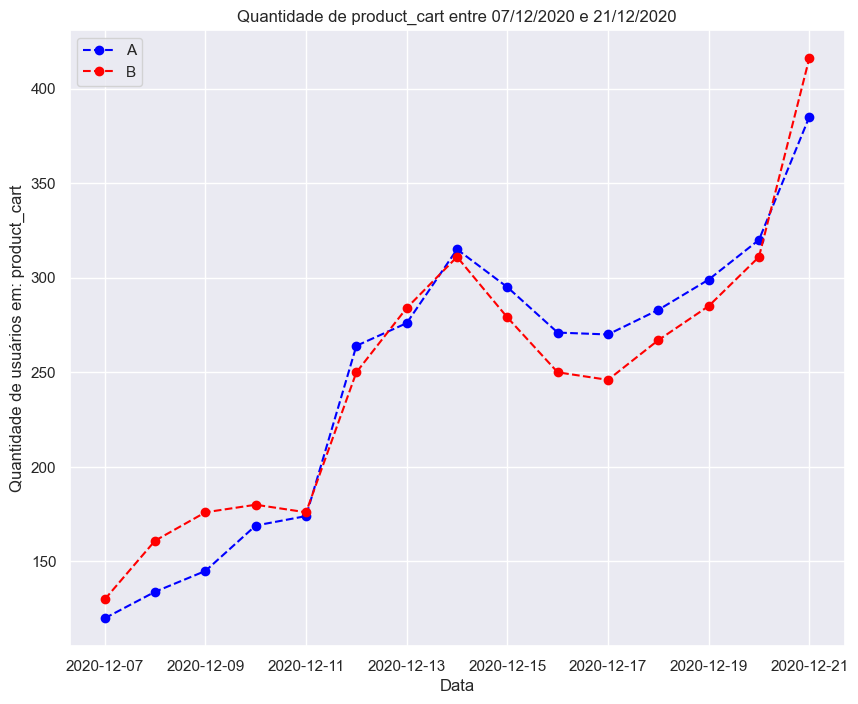

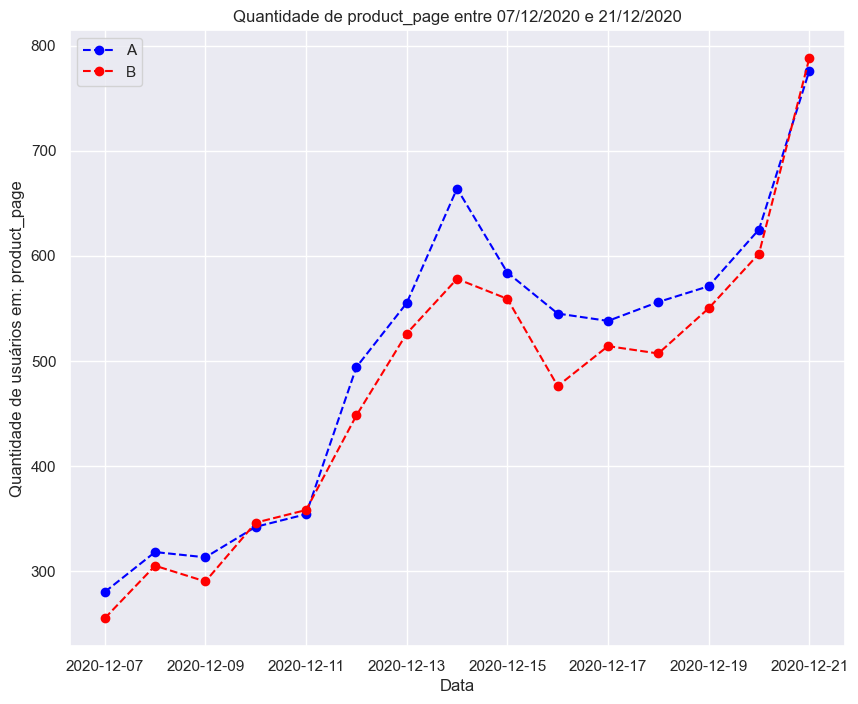

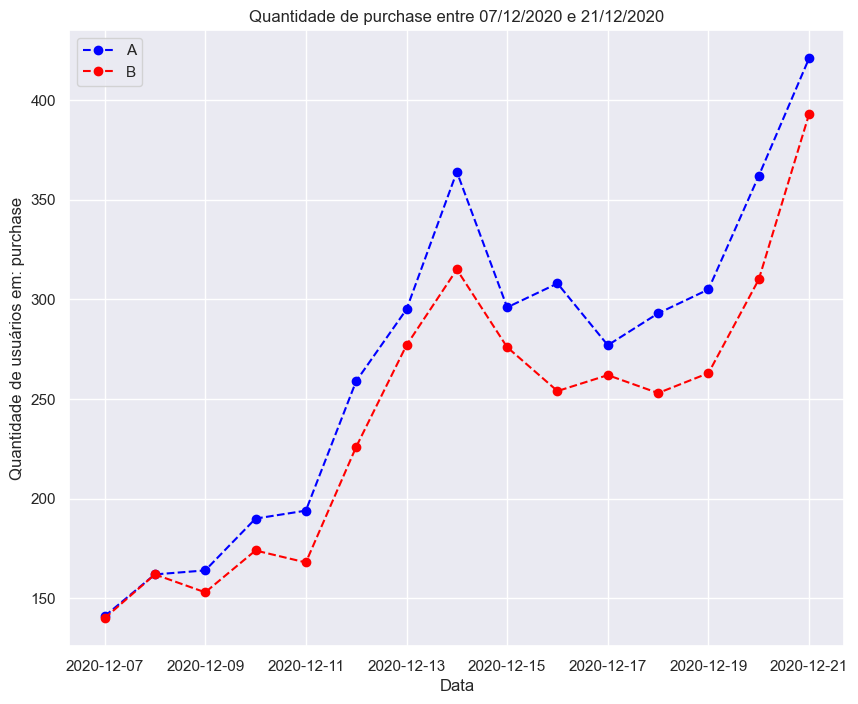

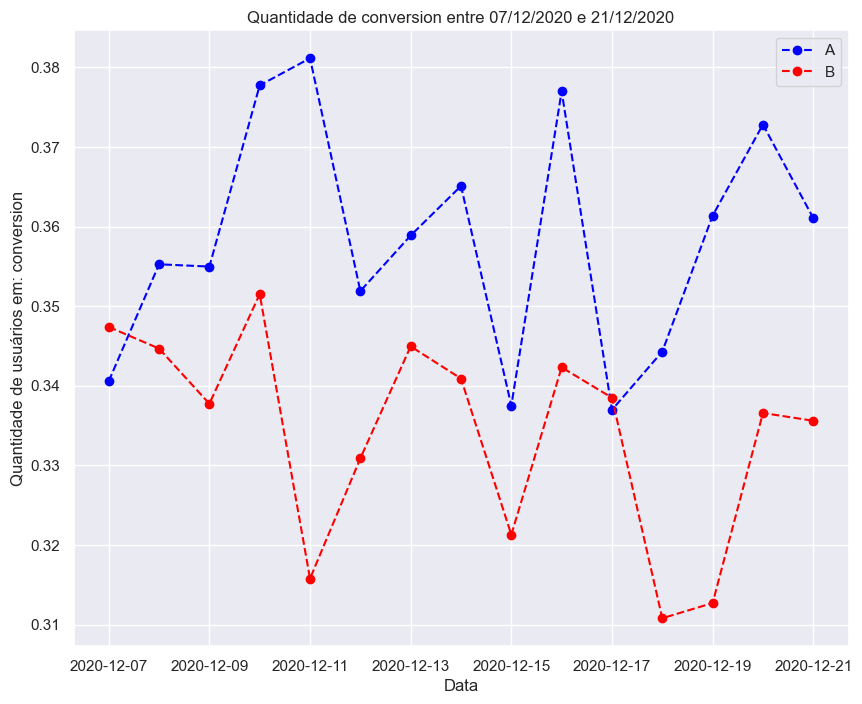

In [80]:
for i in events_ab_pivot.columns[2:]:

    line_plot(event_interface_eu_test, ev=i)

### Plotagem dde Gráficos de Linha dos Grupos A e B do teste recommender_system_test

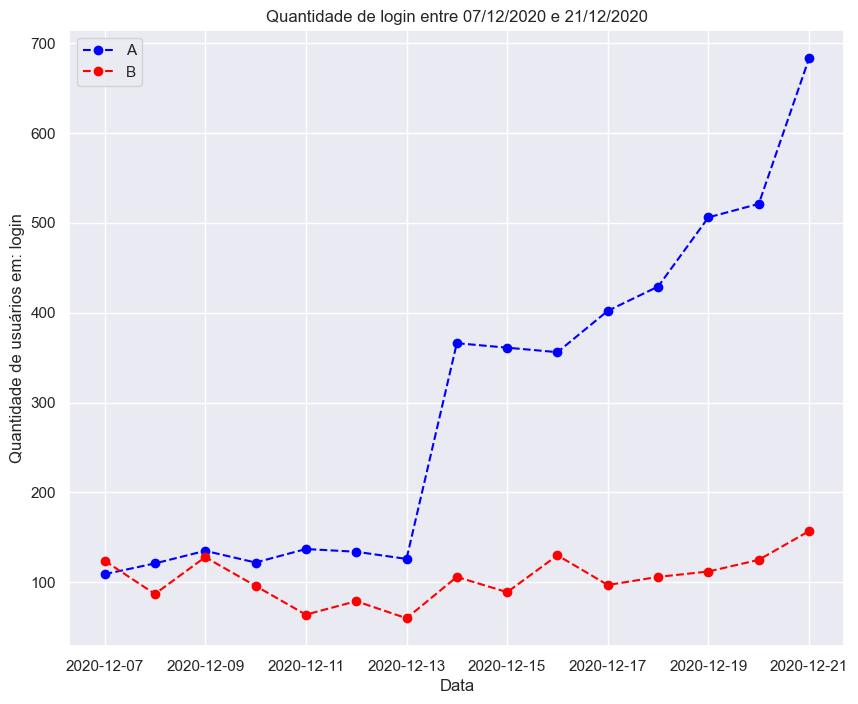

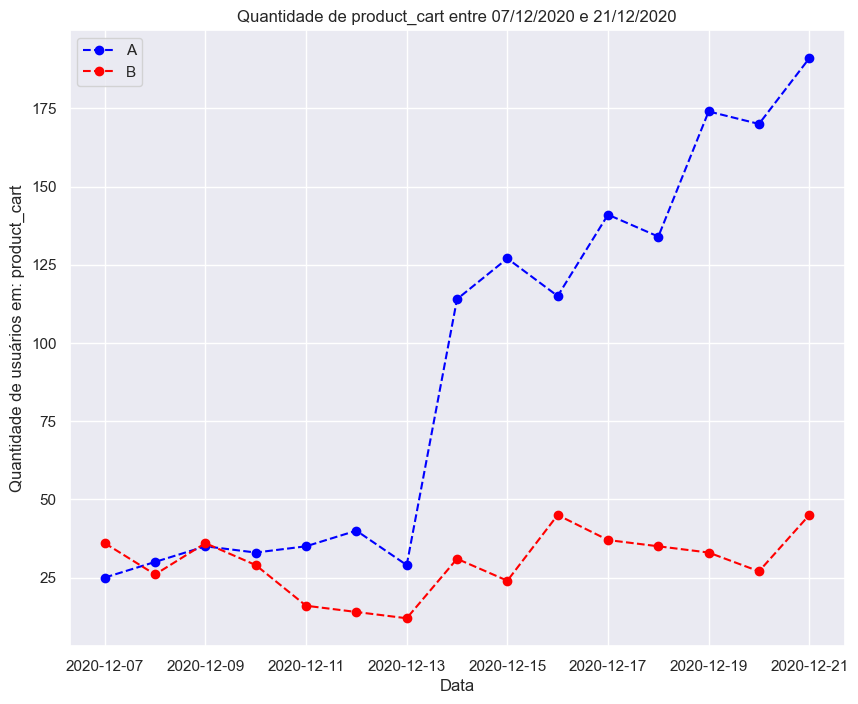

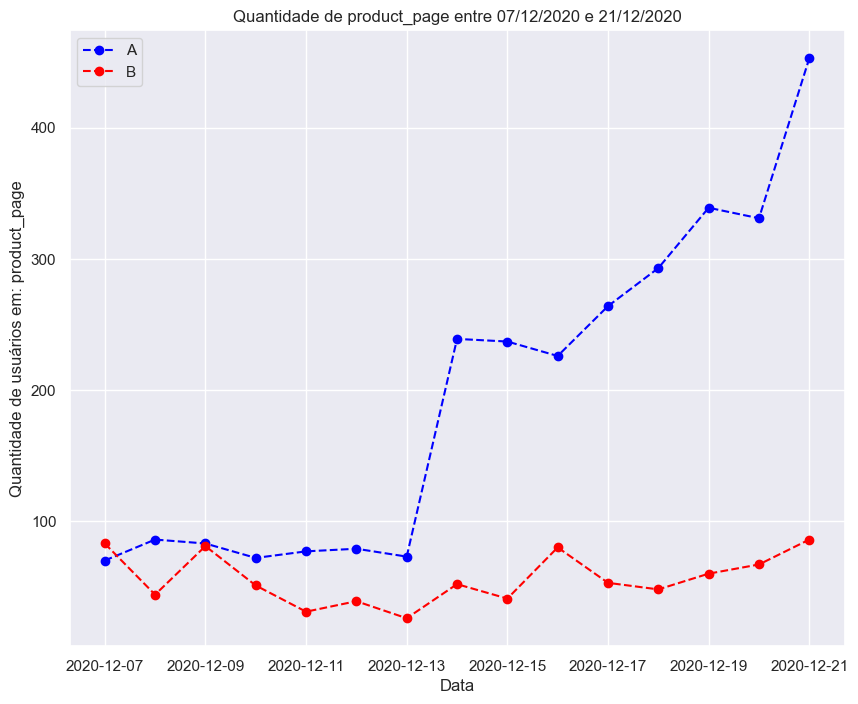

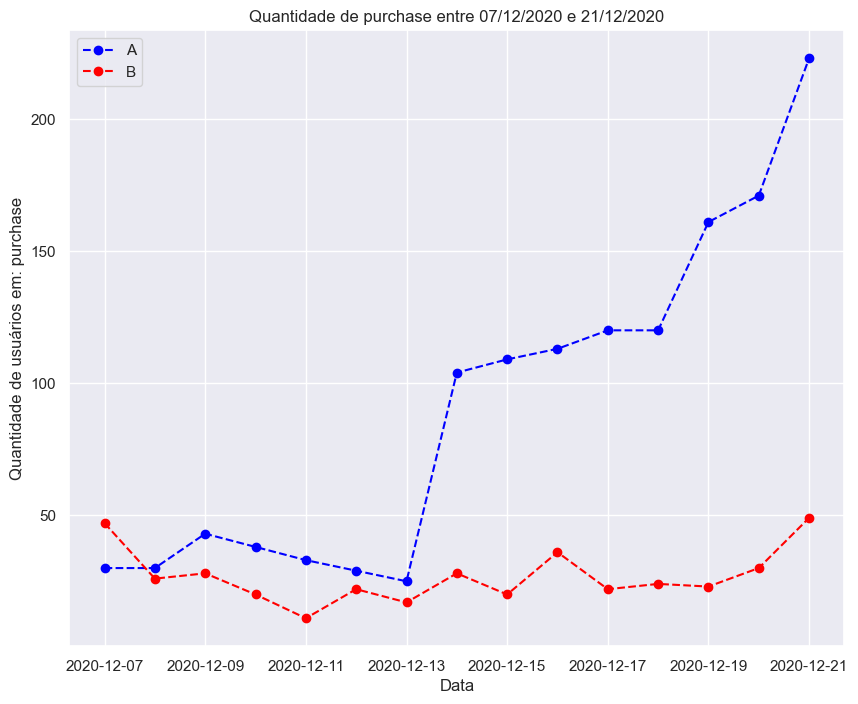

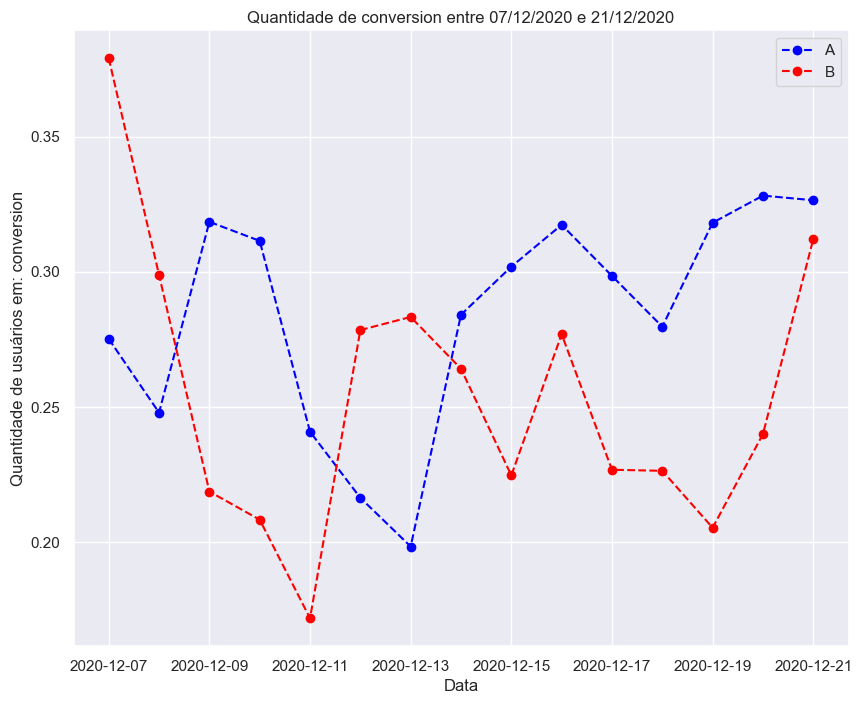

In [81]:
event_recommender_system_test = event_pivot.query('ab_test == "recommender_system_test"')

for i in events_ab_pivot.columns[2:]:

    line_plot(event_recommender_system_test, ev=i)

Aqui também, vemos que os dados parecem seguir as mesmas direções. O comportamento é bem similar entre um grupo e outro.

### Plotagem dos Gráficos de Caixa

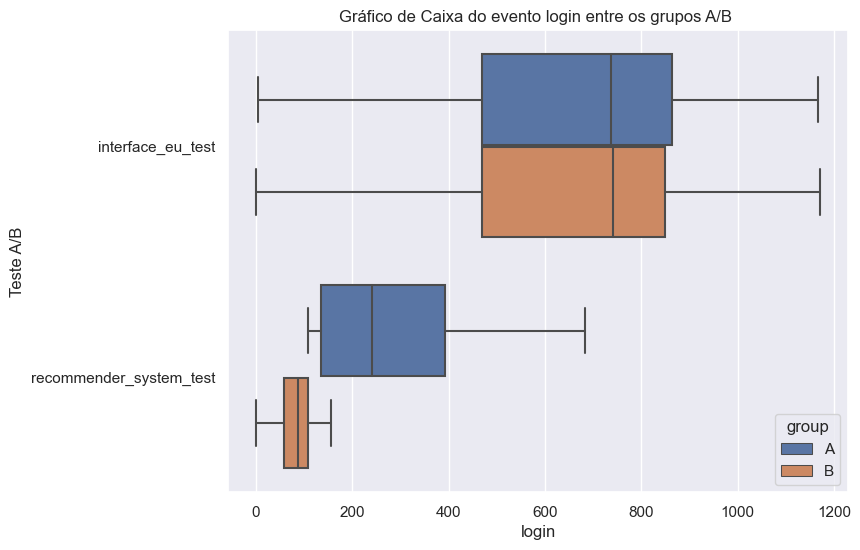

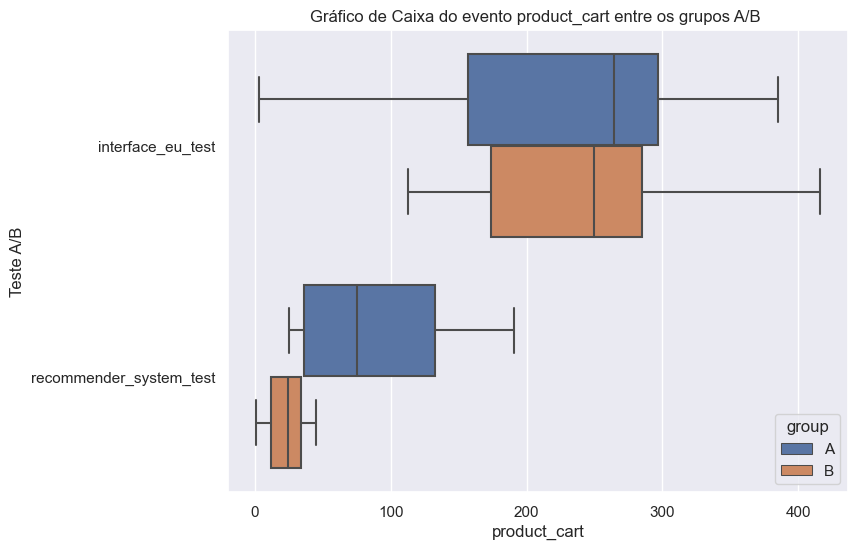

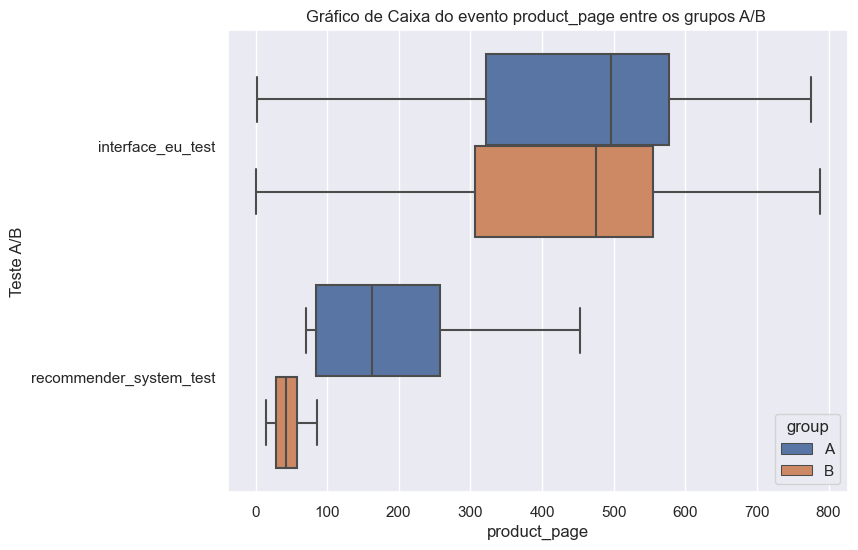

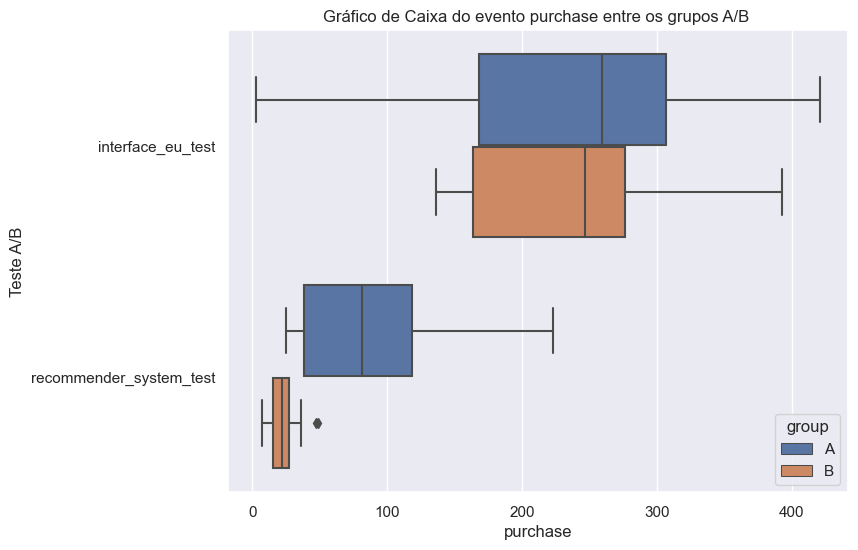

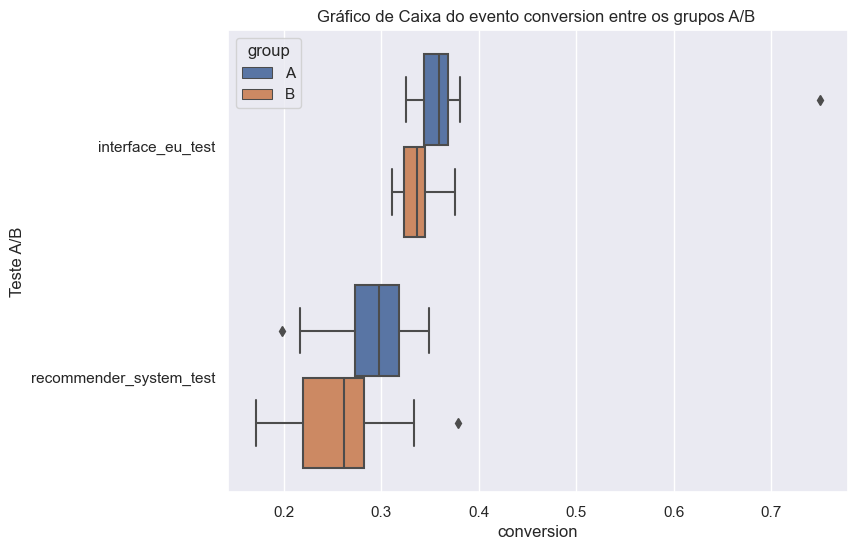

In [82]:
for i in event_pivot.columns[3:]:

    plt.figure(figsize=(8,6))
    sns.boxplot(data= event_pivot, x=i, y='ab_test', orient='h', hue='group')
    plt.title(f"Gráfico de Caixa do evento {i} entre os grupos A/B ")
    plt.xlabel(f"{i}")
    plt.ylabel("Teste A/B")

    plt.show()


Com essa plotagem dos gráficos de caixa, podemos ver que os dados do teste `interface_eu_test` são mais próximos que os do grupo de teste `recommender_system_test`, isso se dá pela quantidade de amostras que o primeiro possui. 

### Plotagem dos Gráficos de Densidade dos Grupos A e B - Geral

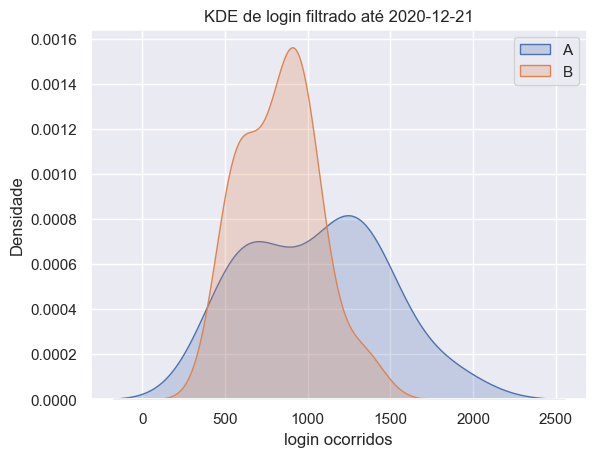

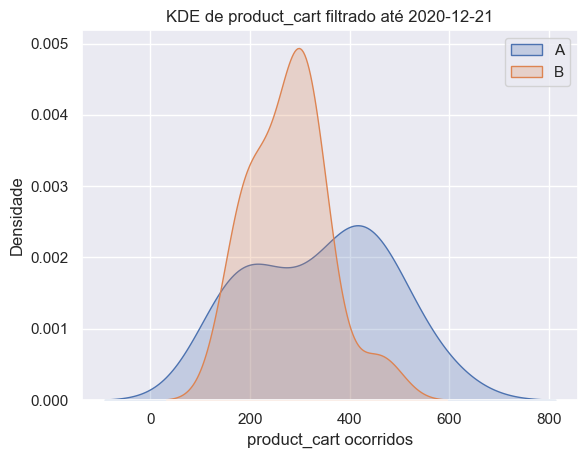

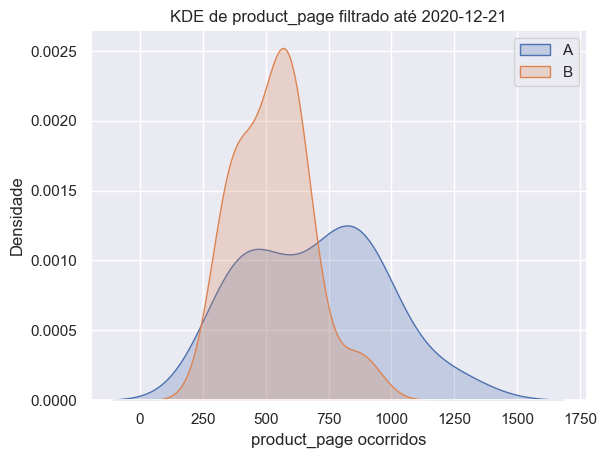

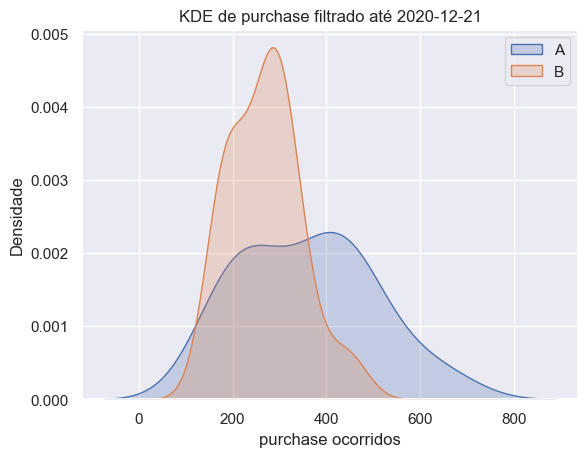

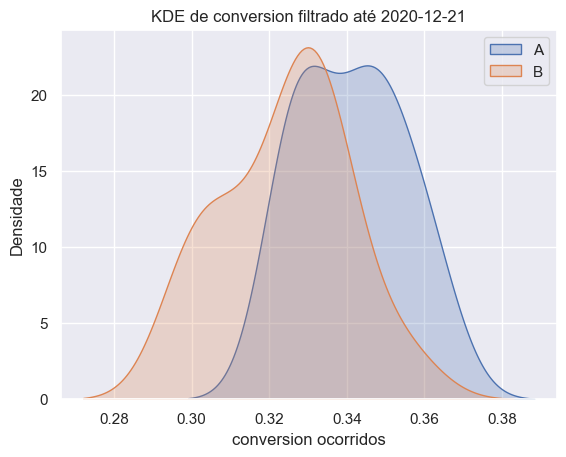

In [83]:
for i in events_ab_pivot.columns[2:]:
    kde_plot(events_ab_pivot, end_data='2020-12-21', ev=i)

Pode-se observar que há uma concentração maior do grupo B em determinados valores, enquanto o grupo A se espalha mais, não há um pico de concentração dos valores.

### Plotagem dos Gráficos de Densidade dos Grupos A e B do teste interface_eu_test

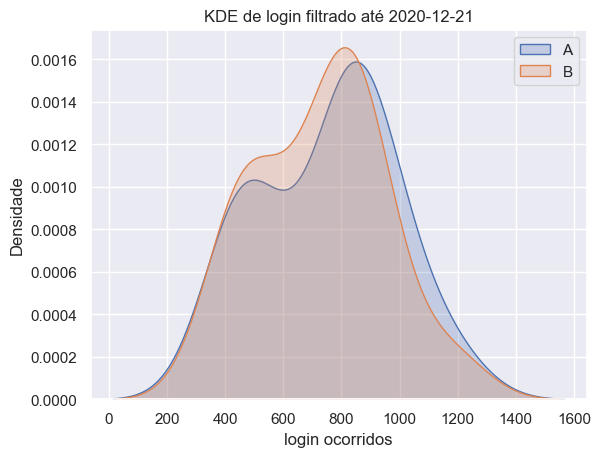

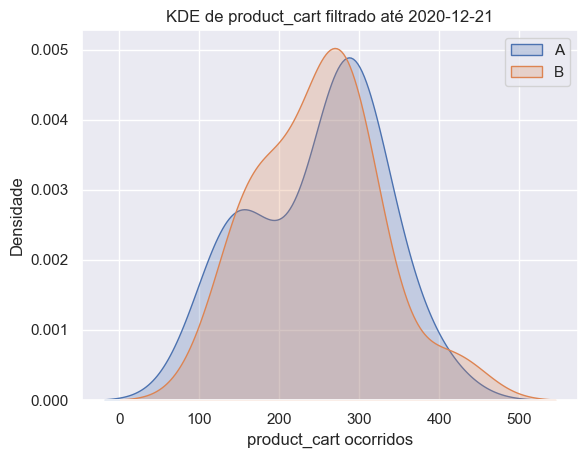

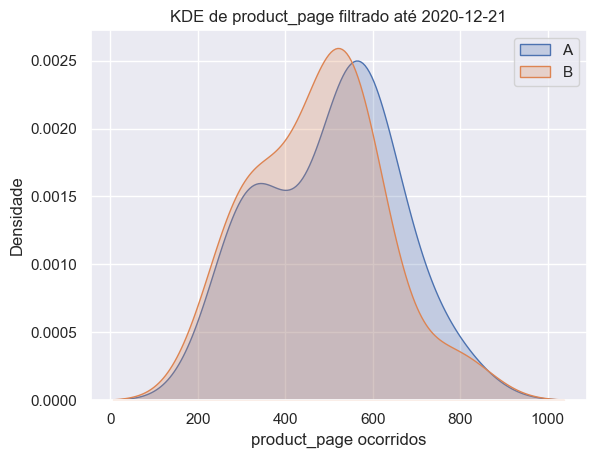

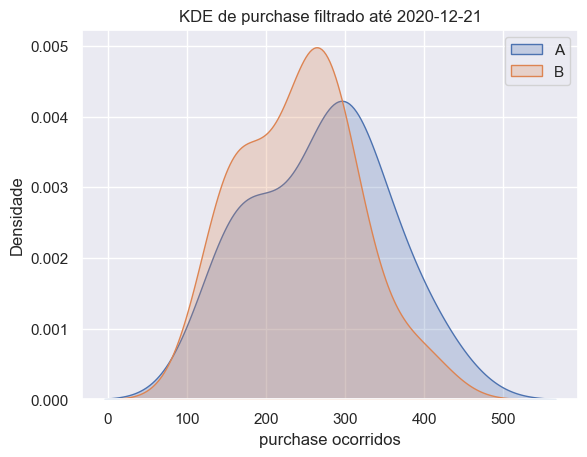

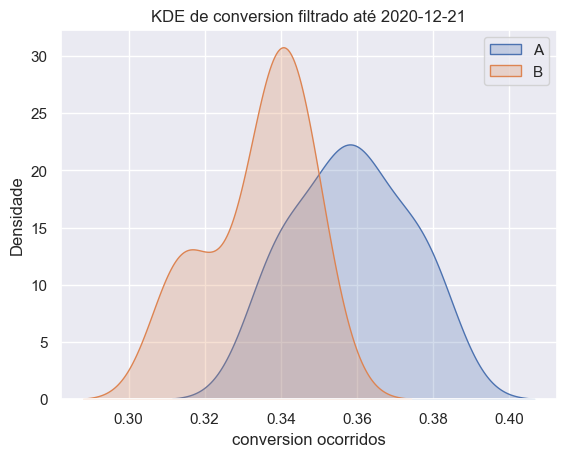

In [84]:
for i in events_ab_pivot.columns[2:]:
    kde_plot(event_interface_eu_test, end_data='2020-12-21', ev=i)

Podemos ver que os grupos **A** e **B** dos teste `interface_eu_test` eles parecem se se distruibir igualmente, assim como vimos no gráfico de caixa, ele por possuir uma quantidade maior de amostras seus grupo **A** e **B** tendem a se aproximar de uma normal. 

### Plotagem dos Gráficos de Densidade dos Grupo A e B do teste recommender_system_test

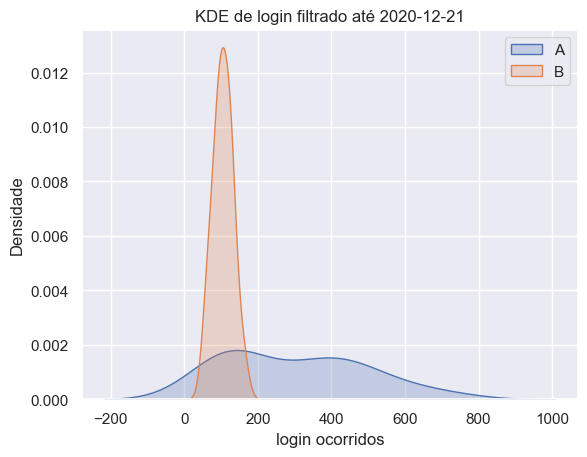

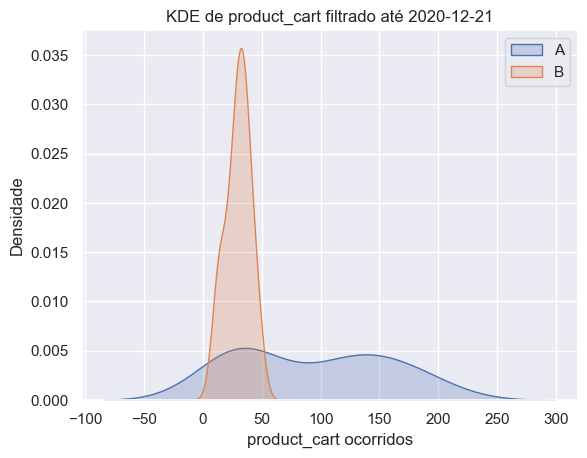

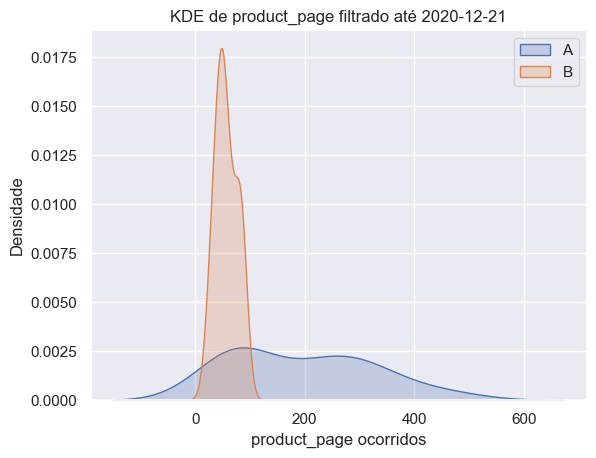

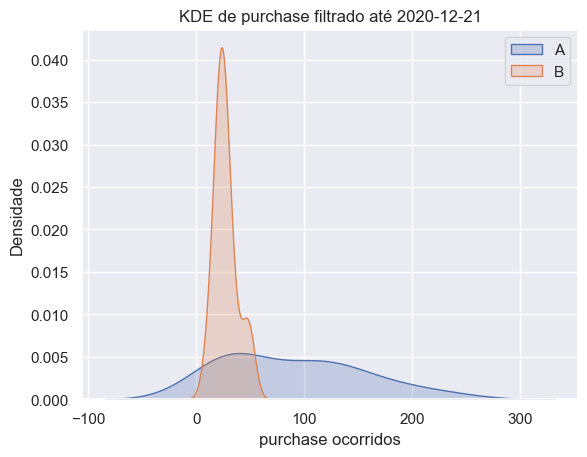

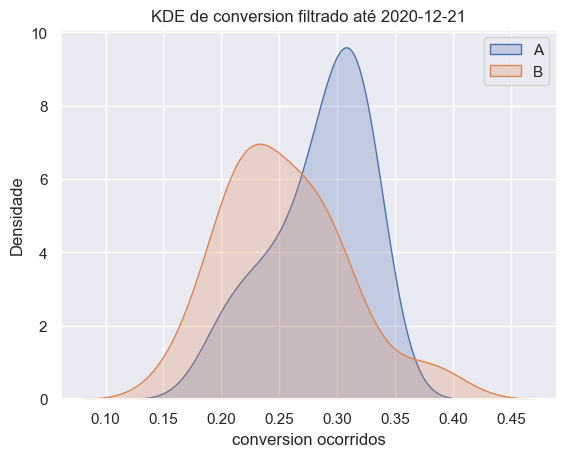

In [85]:
for i in events_ab_pivot.columns[2:]:
    kde_plot(event_recommender_system_test, end_data='2020-12-21', ev=i)

Ao contrário do teste anterior, o `recommender_system_test` não apresenta uma similaridade entre a distribuição dos grupos **A** e **B**. Também podemos tecer o comentário a cerca da quantidade de amostras que é bem inferior ao primeiro grupo analisado nesse tópico.

### Funil de eventos filtrado por Grupos

In [86]:

frequency = events_ab.pivot_table(index=['event_name', 'group'],values='user_id',aggfunc='count').reset_index().sort_values('user_id',ascending= False)

frequency_filtered = frequency.reindex([0,1,4,5,2,3,6,7])


fig = px.funnel(frequency_filtered, x='user_id', y='event_name', color='group', title='Funil de Eventos por grupo - Geral')
fig.show()

In [87]:
frequency = events_ab.query('date <= "2020-12-21"').pivot_table(index=['event_name', 'group'],values='user_id',aggfunc='count').reset_index().sort_values('user_id',ascending= False)

frequency_filtered = frequency.reindex([0,1,4,5,2,3,6,7])


fig = px.funnel(frequency_filtered, x='user_id', y='event_name', color='group', title='Funil de Eventos por grupo - Filtrado entre 07/12/2020 até 21/12/2020')
fig.show()

In [88]:
frequency = events_ab.query('date <= "2020-12-21" & ab_test == "interface_eu_test"').pivot_table(index=['event_name', 'group'],values='user_id',aggfunc='count').reset_index().sort_values('user_id',ascending= False)

frequency_filtered = frequency.reindex([0,1,4,5,2,3,6,7])


fig = px.funnel(frequency_filtered, x='user_id', y='event_name', color='group', title='Funil de Eventos por grupo do teste interface_eu_ab - Filtrado entre 07/12/2020 até 21/12/2020')
fig.show()

In [89]:
frequency = events_ab.query('date <= "2020-12-21" & ab_test == "recommender_system_test"').pivot_table(index=['event_name', 'group'],values='user_id',aggfunc='count').reset_index().sort_values('user_id',ascending= False)

frequency_filtered = frequency.reindex([0,1,4,5,2,3,6,7])


fig = px.funnel(frequency_filtered, x='user_id', y='event_name', color='group', title='Funil de Eventos por grupo do teste recommender_system_ab - Filtrado entre 07/12/2020 até 21/12/2020')
fig.show()

Bem a análise dos funis de eventos corrobora ainda mais com as outros informações passadas pelos dados, o test `recommender_system_test` possui menos amostras. Logo, qualquer comentários que tecermos aqui seria inconclusivo e irresponsável. 

Portanto, dependemos dos testes estatísticos para termos respostas mais concretas.

### Teste Estatísticos

=========================================================================== Teste de normalidade Shapiro e QQ-plot ===========================================================================


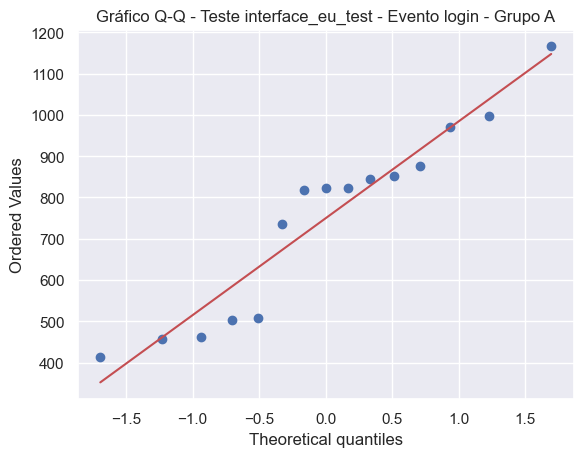

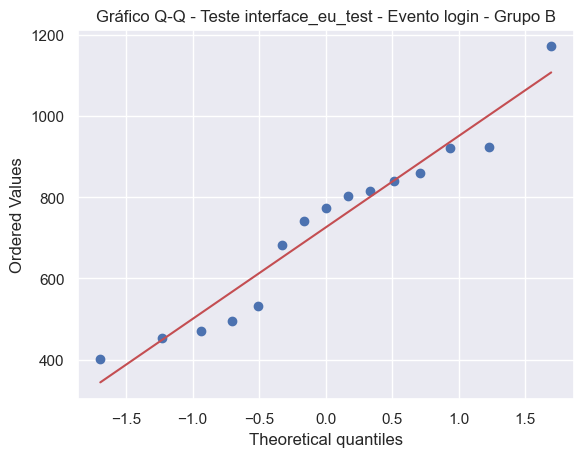

Os dados do evento login dos grupos A e B do teste interface_eu_test podem ser considerados aproximadamente normais. 
P_valor grupo A: 0.15606515109539032
P_valor grupo B: 0.4025879502296448

================================================================================ Teste de Levene =============================================================================================
Não há evidências suficientes para rejeitar a hipótese de homogeneidade de variâncias entre das amostras 1 e 2, dos grupo A e B teste interface_eu_test e do evento login.
P_valor:0.9258134270067452

================================================================================ Teste de T ==================================================================================================
Diferença Estatística de login entre os Grupos: A e B do teste interface_eu_test - Teste T
p-value:  0.7693
Falha ao rejeitar a Hipótese Nula. Não há diferença estatística entre as amostras
P_valor:0.7692681900478229

=========

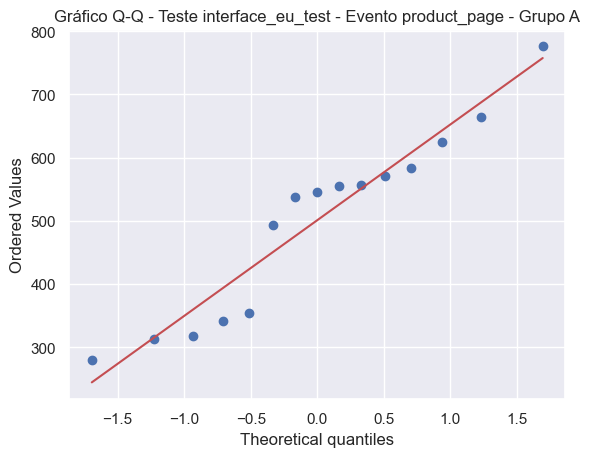

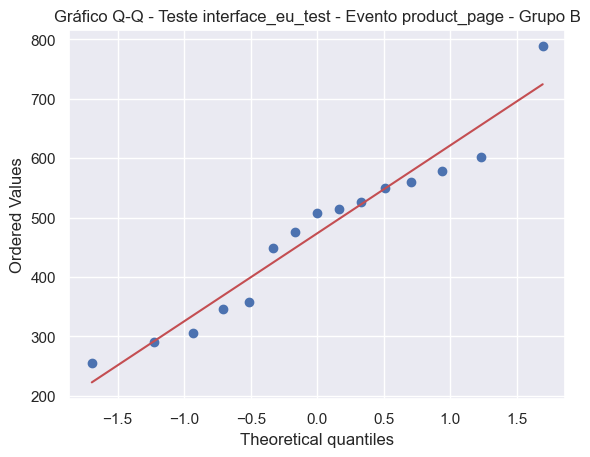

Os dados do evento product_page dos grupos A e B do teste interface_eu_test podem ser considerados aproximadamente normais. 
P_valor grupo A: 0.21549546718597412
P_valor grupo B: 0.515413224697113

================================================================================ Teste de Levene =============================================================================================
Não há evidências suficientes para rejeitar a hipótese de homogeneidade de variâncias entre das amostras 1 e 2, dos grupo A e B teste interface_eu_test e do evento product_page.
P_valor:0.9213686194024995

================================================================================ Teste de T ==================================================================================================
Diferença Estatística de product_page entre os Grupos: A e B do teste interface_eu_test - Teste T
p-value:  0.607
Falha ao rejeitar a Hipótese Nula. Não há diferença estatística entre as amostras
P_valor:0.60701485

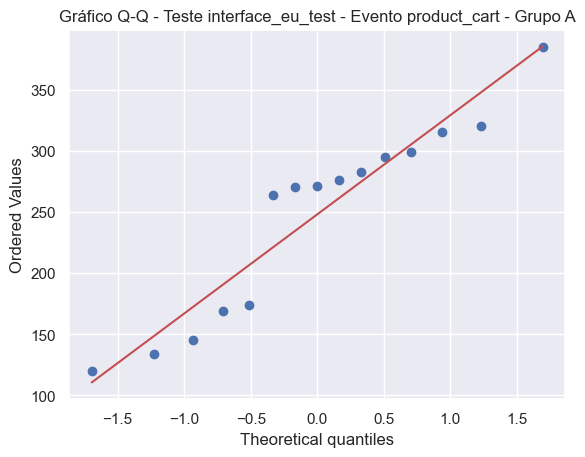

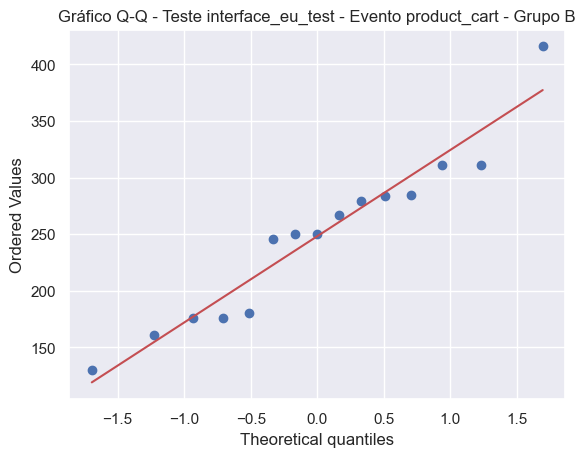

Os dados do evento product_cart dos grupos A e B do teste interface_eu_test podem ser considerados aproximadamente normais. 
P_valor grupo A: 0.12750175595283508
P_valor grupo B: 0.4126124083995819

================================================================================ Teste de Levene =============================================================================================
Não há evidências suficientes para rejeitar a hipótese de homogeneidade de variâncias entre das amostras 1 e 2, dos grupo A e B teste interface_eu_test e do evento product_cart.
P_valor:0.8232386427488041

================================================================================ Teste de T ==================================================================================================
Diferença Estatística de product_cart entre os Grupos: A e B do teste interface_eu_test - Teste T
p-value:  0.9962
Falha ao rejeitar a Hipótese Nula. Não há diferença estatística entre as amostras
P_valor:0.996237

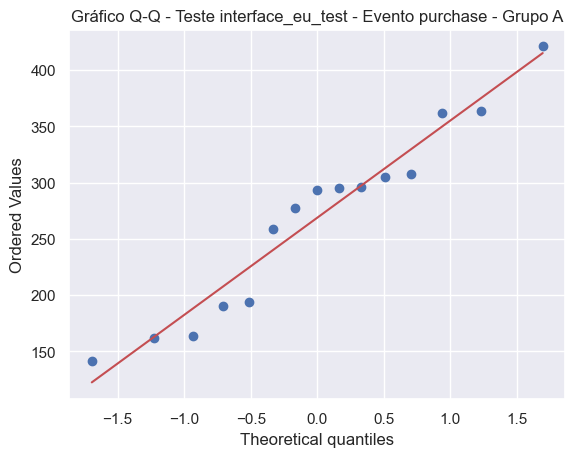

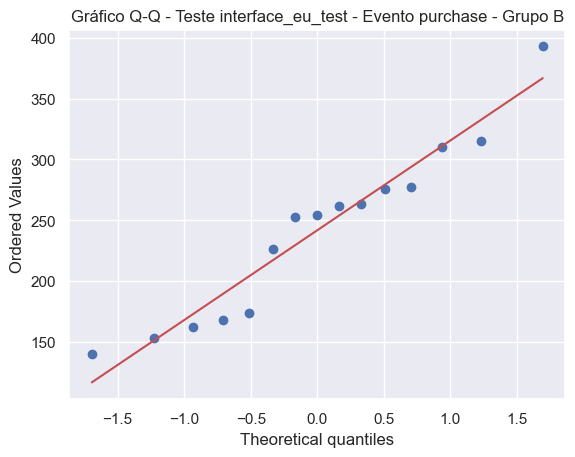

Os dados do evento purchase dos grupos A e B do teste interface_eu_test podem ser considerados aproximadamente normais. 
P_valor grupo A: 0.42012476921081543
P_valor grupo B: 0.3619978129863739

================================================================================ Teste de Levene =============================================================================================
Não há evidências suficientes para rejeitar a hipótese de homogeneidade de variâncias entre das amostras 1 e 2, dos grupo A e B teste interface_eu_test e do evento purchase.
P_valor:0.6084446298503836

================================================================================ Teste de T ==================================================================================================
Diferença Estatística de purchase entre os Grupos: A e B do teste interface_eu_test - Teste T
p-value:  0.3476
Falha ao rejeitar a Hipótese Nula. Não há diferença estatística entre as amostras
P_valor:0.34764689408984106


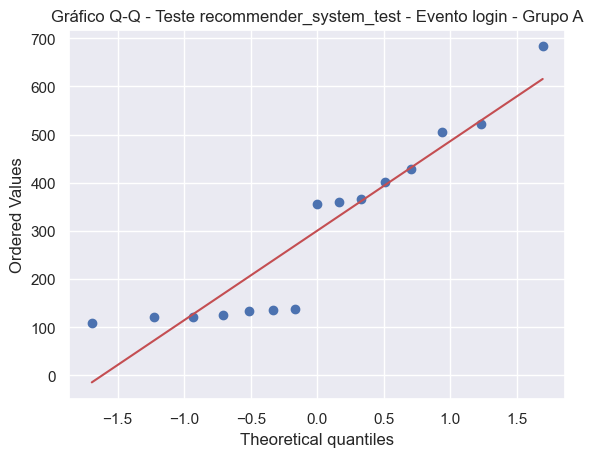

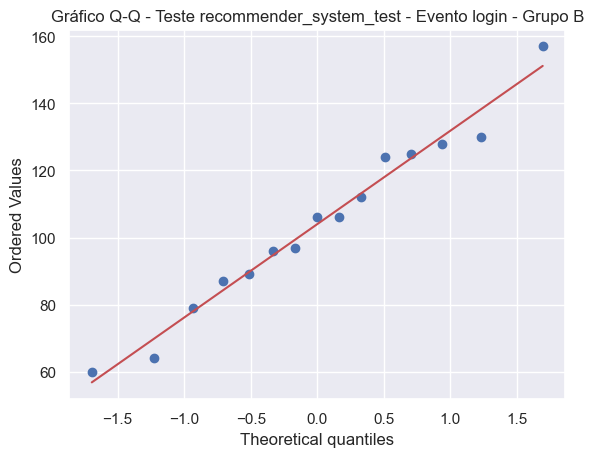

Os dados do evento login dos grupos A e B do teste recommender_system_test não seguem uma distribuição normal.
P_valor grupo A: 0.022181475535035133
P_valor grupo B: 0.9478330612182617

================================================================================ Teste de Mann-Whitney =======================================================================================
Diferença Estatística de login entre os Grupos: A e B do teste recommender_system_test, evento login - Teste Mann-Whitney
p-value:  0.0002
Hipótese nula rejeitada: Há diferença estatística significante entre as amostras.


=========================================================================== Teste de normalidade Shapiro e QQ-plot ===========================================================================


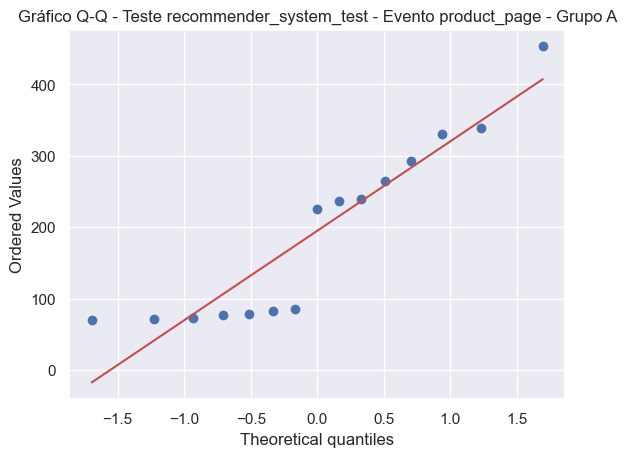

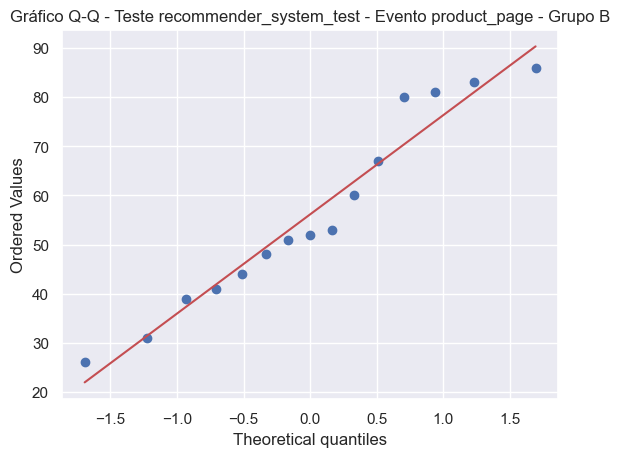

Os dados do evento product_page dos grupos A e B do teste recommender_system_test não seguem uma distribuição normal.
P_valor grupo A: 0.020074404776096344
P_valor grupo B: 0.32264408469200134

================================================================================ Teste de Mann-Whitney =======================================================================================
Diferença Estatística de product_page entre os Grupos: A e B do teste recommender_system_test, evento product_page - Teste Mann-Whitney
p-value:  0.0002
Hipótese nula rejeitada: Há diferença estatística significante entre as amostras.


=========================================================================== Teste de normalidade Shapiro e QQ-plot ===========================================================================


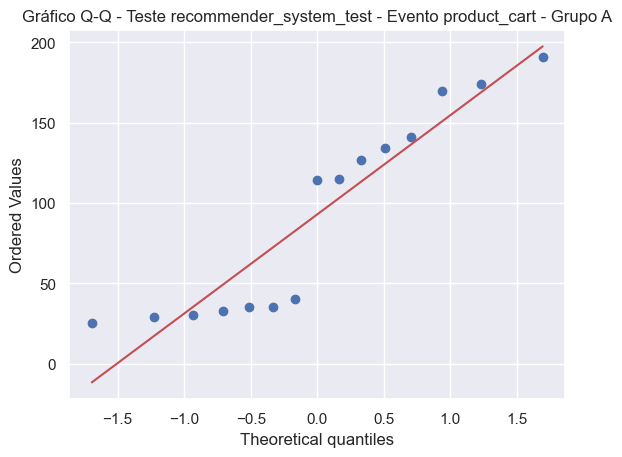

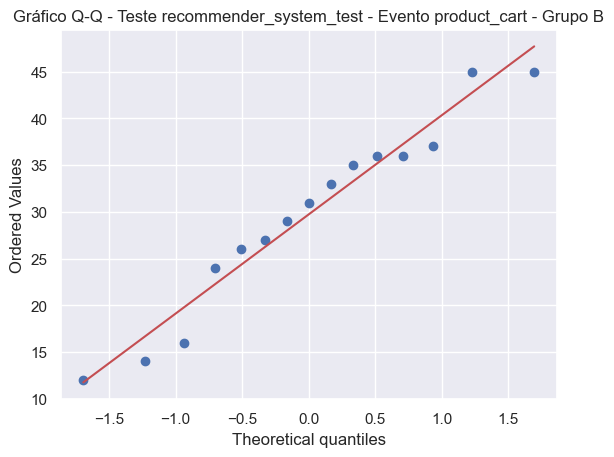

Os dados do evento product_cart dos grupos A e B do teste recommender_system_test não seguem uma distribuição normal.
P_valor grupo A: 0.014084862545132637
P_valor grupo B: 0.48129233717918396

================================================================================ Teste de Mann-Whitney =======================================================================================
Diferença Estatística de product_cart entre os Grupos: A e B do teste recommender_system_test, evento product_cart - Teste Mann-Whitney
p-value:  0.007
Hipótese nula rejeitada: Há diferença estatística significante entre as amostras.


=========================================================================== Teste de normalidade Shapiro e QQ-plot ===========================================================================


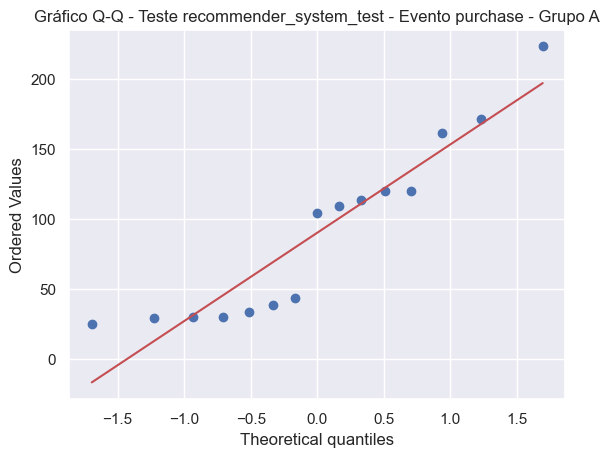

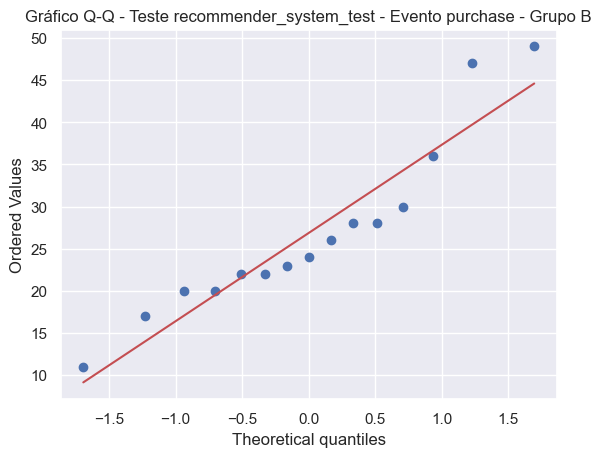

Os dados do evento purchase dos grupos A e B do teste recommender_system_test não seguem uma distribuição normal.
P_valor grupo A: 0.034084029495716095
P_valor grupo B: 0.09821708500385284

================================================================================ Teste de Mann-Whitney =======================================================================================
Diferença Estatística de purchase entre os Grupos: A e B do teste recommender_system_test, evento purchase - Teste Mann-Whitney
p-value:  0.0003
Hipótese nula rejeitada: Há diferença estatística significante entre as amostras.




In [90]:
#Testes Estatísticos

cumulative_event_filtered = cumulative_event.query('date <= "2020-12-21"')


ab_var = ['login', 'product_page', 'product_cart', 'purchase']

ab_test = cumulative_event_filtered.ab_test.unique()

event_filtro = event_pivot.query('date <= "2020-12-21"')


for i in ab_test:
    for j in ab_var:
       
        #--------------------------------------------- Parâmetros ----------------------------------------
        sample_1 = event_filtro[(event_filtro['ab_test'] == i) & (event_filtro['group'] == 'A')][j]
        sample_2 = event_filtro[(event_filtro['ab_test'] == i) & (event_filtro['group'] == 'B')][j]
        
        _, p_shapiro_s1 = stats.shapiro(sample_1)
        _, p_shapiro_s2 = stats.shapiro(sample_2)

        _, p_levene = stats.levene(sample_1, sample_2)

        # ------------------------------------------------------------------------------------------------


        #------------------------------------------- Shapiro ---------------------------------------------

        print('='*190)
        print('='*75, 'Teste de normalidade Shapiro e QQ-plot', '='*75)
        print('='*190)

        stats.probplot(sample_1, dist="norm", plot=plt)
        plt.title(f"Gráfico Q-Q - Teste {i} - Evento {j} - Grupo A")
        plt.show()

        stats.probplot(sample_2, dist="norm", plot=plt)
        plt.title(f"Gráfico Q-Q - Teste {i} - Evento {j} - Grupo B")
        plt.show()

        if p_shapiro_s1 > .05 and p_shapiro_s2 > .05:                              # Shapiro-Wilk
            print(f"Os dados do evento {j} dos grupos A e B do teste {i} podem ser considerados aproximadamente normais. ")
            print(f'P_valor grupo A: {p_shapiro_s1}')
            print(f'P_valor grupo B: {p_shapiro_s2}')
            print()
      

        #--------------------------------------------Shapiro == True ----------------------------------------

            print('='*190)
            print('='*80, 'Teste de Levene', '='*93)
            print('='*190)

            if p_levene > .05:                                                          # Levene
                print(f"Não há evidências suficientes para rejeitar a hipótese de homogeneidade de variâncias entre das amostras 1 e 2, dos grupo A e B teste {i} e do evento {j}.")
                print(f'P_valor:{p_levene}')
                print()

                #--------------------------------------------- T-Student ---------------------------------
                results = stats.ttest_ind(sample_1,sample_2)
                alpha = 0.05
            
                print('='*190)
                print('='*80, 'Teste de T', '='*98)                                     #Teste T
                print('='*190)

                print(f'Diferença Estatística de {j} entre os Grupos: A e B do teste {i} - Teste T')
                print('p-value: ', results.pvalue.round(4))

                if (results.pvalue < alpha):
                    print("Hipótese nula rejeitada: Há diferença estatística significante entre as amostras.")
                    print(f'P_valor:{results.pvalue}')
                    print()
                else:
                    print("Falha ao rejeitar a Hipótese Nula. Não há diferença estatística entre as amostras") 
                    print(f'P_valor:{results.pvalue}')
                    print() 

            
            else:

                print(f"Há evidências suficientes para rejeitar a hipótese de homogeneidade de variâncias entre as amostras 1 e 2, dos grupo A teste {i} e do evento {j}. Portanto será usado o teste de Mann-Whitney ")
                print(f'P_valor:{p_levene}')
                print()    

                
                #------------------------------------------ Welch -----------------------------------------     
            
                               
                _, p = stats.ttest_ind(sample_1, sample_2, equal_var=False)
                alpha = 0.05

                print('='*190)
                print('='*80, 'Teste de T-Welch', '='*80)                               # Teste Welch
                print('='*190)

                print(f'Diferença Estatística de {j} entre os Grupos: A e B do teste {i}, evento {j} - Teste Mann-Whitney')
                print('p-value: ', p.round(4))
                if (p < alpha):
                    print("Hipótese nula rejeitada: Há diferença estatística significante entre as amostras.")
                    print(f'P_valor:{p}')
                    print()
                else:
                    print("Falha ao rejeitar a Hipótese Nula. Não há diferença estatística entre as amostras") 
                    print(f'P_valor:{p}')
                    print()
                
                print('='*190)
                print()

        #------------------------------------------------ Shapiro == False ---------------------------------------------------      
        else:
            print(f"Os dados do evento {j} dos grupos A e B do teste {i} não seguem uma distribuição normal.") 
            print(f'P_valor grupo A: {p_shapiro_s1}')
            print(f'P_valor grupo B: {p_shapiro_s2}')
            print() 


            #------------------------------------------------ Teste Mann-Whitney --------------------------------------------- 

            results = stats.mannwhitneyu(sample_1, sample_2)
            alpha = 0.05

            print('='*190)
            print('='*80, 'Teste de Mann-Whitney', '='*87)                               # Teste Mann-Whitney
            print('='*190)

            print(f'Diferença Estatística de {j} entre os Grupos: A e B do teste {i}, evento {j} - Teste Mann-Whitney')
            print('p-value: ', results.pvalue.round(4))
            if (results.pvalue < alpha):
                print("Hipótese nula rejeitada: Há diferença estatística significante entre as amostras.")
                print()
            else:
                print("Falha ao rejeitar a Hipótese Nula. Não há diferença estatística entre as amostras") 
                print()
                
            print('='*190)
            print()



Bem, diante do resultado dos testes estatísticos vemos que no teste `interface_eu_test` não há diferença estatística entre as amostras dos grupo A e B, tendo em todos os eventos H0 não sendo rejeitado.

Enquanto, no teste `recommender_system_test` as amostras não suguem uma distribuição normal muito provavelmente por falta de amostras no grupo onde o grupo **A** pussui 14215 indivíduos e grupo **B**, apenas 3979.



# Conclusão Final

Primeiramente, percebe-se que não foi dispensada a devida atenção ao testa A/B pela equipe passada. Uma vez que havia indivíduos que participavam dos dois grupos. O número de participantes não foi planejado adequadamente, grupos com amostras muito maiores que as outras. 

Houve a possibilidade de percebermos algumas informações pertinentes, como a maioria das visitas foram as segundas, mesmo que nun período curto de 14 dias, sendo extendido ao máximo de quase 1 mês. Os dispositivos que mais se destacam são Androids e PC.

Quando observamos o funil de eventos sem filtrar os grupos, vemos que não há diferença significante entre os grupos. O que foge do normal é o número de compra superar o número de visitas a página do carrinho, o que pode sugerir uma forma diferenciada de compra. 


A cerca dos testes estatísticos, eles são inconclusivos, uma vez que os dados não foram tratados, nem colhidos, de forma adequada pela última equipe. Ambos os testes não tiveram impacto significativo.

Logo, não podemos concluir que as mudanças do sistemas devem ser mantidas, ampliadas ou descartadas.

# Link para PDF

https://drive.google.com/file/d/1jHHULyIR2DqHKH1FUBaQTJJiaF6ETZyY/view?usp=sharing

# Link para o Dashboard do Tableau

https://public.tableau.com/app/profile/raphael.ramier/viz/Projeto_Final_TripleTen/Painel1?publish=yes